# **Load Dataset**

In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload your kaggle.json file
from google.colab import files
print("Upload your kaggle.json file")
files.upload() # This will prompt you to upload your kaggle.json

# Create Kaggle directory and move the json file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset (adjust if it's a dataset, not a competition)
# Replace 'glioma-mcd-2025' if your competition/dataset name is different
!kaggle competitions download -c glioma-mcd-2025

# Create a directory to extract files
!mkdir -p /content/glioma_data

# Unzip the downloaded file into the created directory
# The zip file name might be 'glioma-mcd-2025.zip' or similar.
# Check the output of the download command.
!unzip -q glioma-mcd-2025.zip -d /content/glioma_data

# Verify by listing contents (Adjust path if needed based on zip structure)
print("\nContents of the unzipped data directory:")
!ls /content/glioma_data
# You might need to list a subdirectory like:
# !ls /content/glioma_data/Data_122824/Glioma_MDC_2025_training/

import os

TRAIN_DIR_COLAB = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
TEST_DIR_COLAB = "/content/glioma_data/Data_122824/Glioma_MDC_2025_test/" # If you need it later
SUBMISSION_TEMPLATE_PATH_COLAB = "/content/glioma_data/archive/Submission_template.csv"

print(f"Checking TRAIN_DIR_COLAB: {TRAIN_DIR_COLAB}")
if os.path.exists(TRAIN_DIR_COLAB):
    print("TRAIN_DIR_COLAB exists.")
    print("Contents:", os.listdir(TRAIN_DIR_COLAB)[:5]) # Print first 5 items
else:
    print("TRAIN_DIR_COLAB DOES NOT exist. Please check the path.")

print(f"\nChecking TEST_DIR_COLAB: {TEST_DIR_COLAB}")
if os.path.exists(TEST_DIR_COLAB):
    print("TEST_DIR_COLAB exists.")
    print("Contents:", os.listdir(TEST_DIR_COLAB)[:5])
else:
    print("TEST_DIR_COLAB DOES NOT exist. Please check the path or if it's part of the download.")

print(f"\nChecking SUBMISSION_TEMPLATE_PATH_COLAB: {SUBMISSION_TEMPLATE_PATH_COLAB}")
if os.path.exists(SUBMISSION_TEMPLATE_PATH_COLAB):
    print("SUBMISSION_TEMPLATE_PATH_COLAB exists.")
else:
    print("SUBMISSION_TEMPLATE_PATH_COLAB DOES NOT exist. Please check the path.")

Upload your kaggle.json file


Saving kaggle.json to kaggle.json
 86% 329M/382M [00:05<00:01, 42.1MB/s]
100% 382M/382M [00:05<00:00, 68.2MB/s]

Contents of the unzipped data directory:
archive  Data_122824
Checking TRAIN_DIR_COLAB: /content/glioma_data/Data_122824/Glioma_MDC_2025_training/
TRAIN_DIR_COLAB exists.
Contents: ['training1293.jpg', 'training0090.jpg', 'training1407.json', 'training0920.jpg', 'training1258.json']

Checking TEST_DIR_COLAB: /content/glioma_data/Data_122824/Glioma_MDC_2025_test/
TEST_DIR_COLAB exists.
Contents: ['testing0048.jpg', 'testing0058.json', 'testing0035.json', 'testing0147.jpg', 'testing0174.jpg']

Checking SUBMISSION_TEMPLATE_PATH_COLAB: /content/glioma_data/archive/Submission_template.csv
SUBMISSION_TEMPLATE_PATH_COLAB exists.


# **EDA**

Using training directory: /content/glioma_data/Data_122824/Glioma_MDC_2025_training/
Found 1439 JSON files.

--- 1. Class Distribution ---
Total ROIs: 1616
Mitosis: 889 (55.01%)
Non-mitosis: 727 (44.99%)


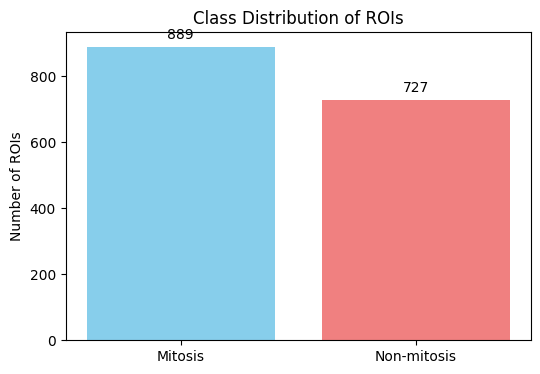


--- 2. ROI Size (Area) Distribution ---
ROI Area Stats - Mean: 2248.68, Median: 2254.00, Min: 30.00, Max: 6699.00, Std: 946.33
Number of valid ROIs with area > 0: 1433


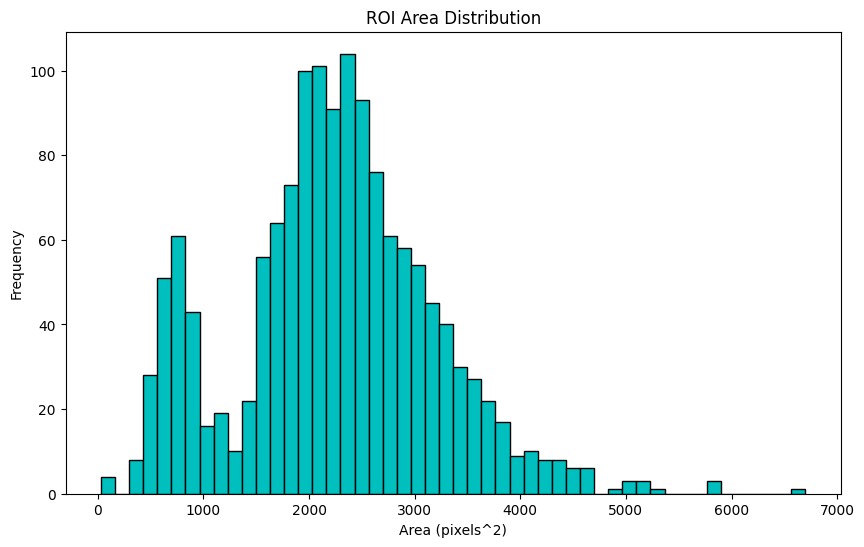

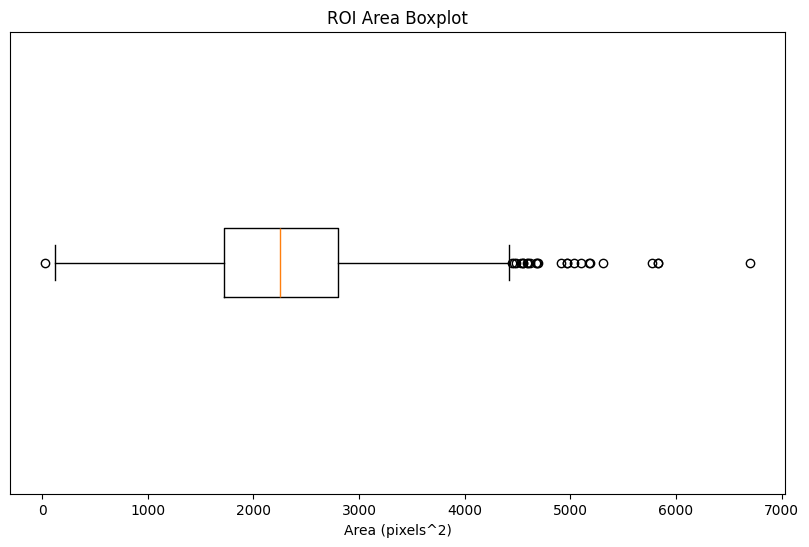


--- 3. ROIs per Image ---
ROIs per Image - Mean: 1.12, Median: 1.00, Min: 1, Max: 3, Std: 0.34


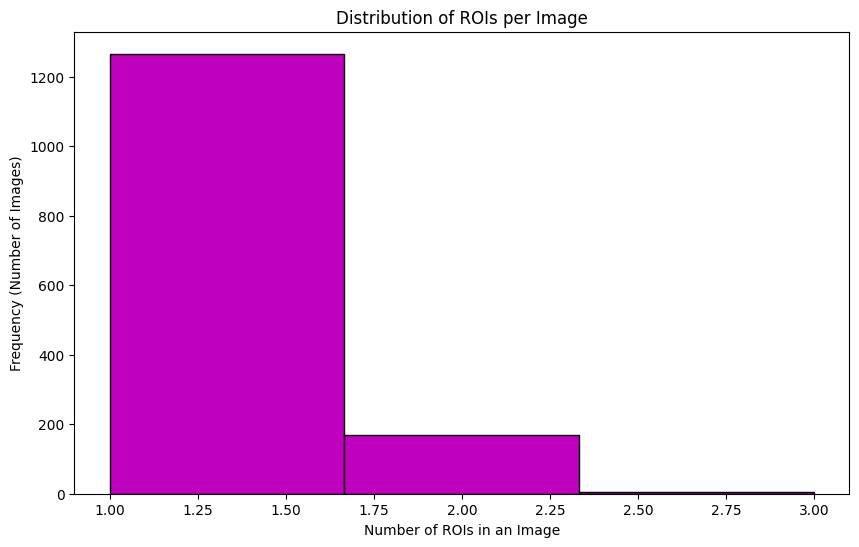


--- 4. Spatial Distribution of ROI Centroids ---
Spatial Distribution (8x8 grid counts based on observed max coordinates):
[[ 36  62  69  41   3   1   0   1]
 [ 55 136 117  88   4   4   1   4]
 [ 76 170 151  85   5   5   8   4]
 [ 51 104  98  59  16   2   2   2]
 [  3  10   9  14  10  10   2   3]
 [  4   9   6   7  11   5   3   3]
 [  1   0   5   4   6   6   2   2]
 [  0   3   2   3   5   1   7   0]]


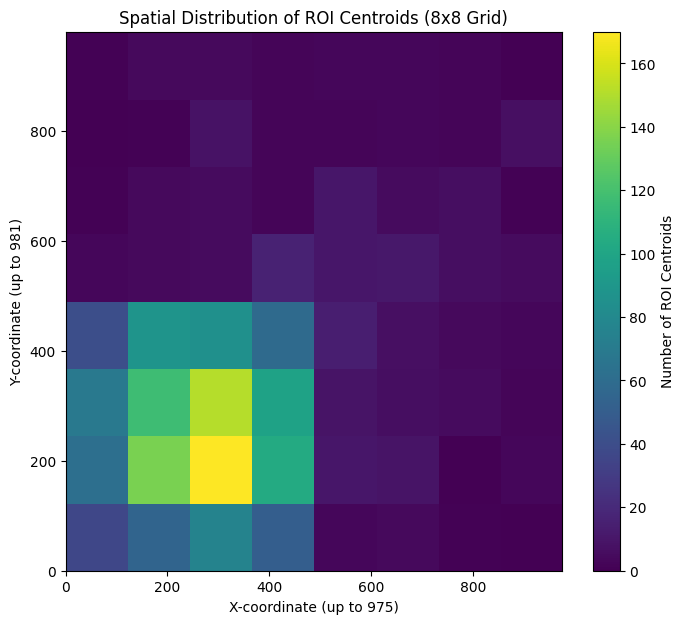


--- 5. Image Intensity Stats (sample based) ---
Analyzing intensity for 50 sample images...
Aggregated Image Intensity (based on 50 valid samples) -
  R: mean=0.596, std=0.166
  G: mean=0.396, std=0.152
  B: mean=0.637, std=0.122
Note: These aggregated stats are useful for setting normalization parameters in transforms.

--- 6. Mitosis vs. Non-mitosis ROI Intensity Comparison ---

ROI Intensity Statistics:
  Mitosis ROIs - Count: 842, Mean Intensity: 0.426, Std: 0.077
  Non-mitosis ROIs - Count: 591, Mean Intensity: 0.472, Std: 0.089


<ipython-input-3-8e9199ea0d39>:333: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels_for_plot, patch_artist=True, medianprops={'color':'black'})


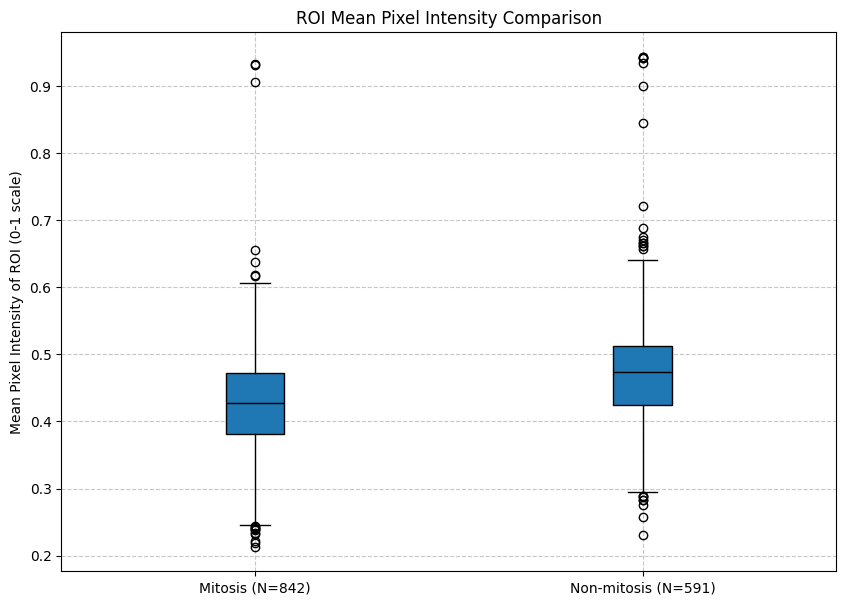


--- EDA Complete ---


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
import math # For math.floor and math.ceil
from PIL import Image
import matplotlib.pyplot as plt

# --- SETTING THE CORRECT PATH FOR COLAB ---
TRAIN_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
print(f"Using training directory: {TRAIN_DIR}")

# --- Helper Function to compute bounding box from polygon points ---
def getc_bbox(points, image_width, image_height):
    """Compute bounding box from polygon points, ensuring it stays within image bounds."""
    if not points:
        return None
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]

    if not xs or not ys:
        return None

    min_x = max(0, int(math.floor(min(xs))))
    max_x = min(image_width, int(math.ceil(max(xs))))
    min_y = max(0, int(math.floor(min(ys))))
    max_y = min(image_height, int(math.ceil(max(ys))))

    if min_x >= max_x or min_y >= max_y:
        return None
    return [min_x, min_y, max_x, max_y]

# --- Load JSON files ---
json_files = []
if os.path.exists(TRAIN_DIR) and os.path.isdir(TRAIN_DIR):
    json_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.json')]
    if not json_files:
        print(f"No JSON files found in {TRAIN_DIR}. EDA will be limited.")
    else:
        print(f"Found {len(json_files)} JSON files.")
else:
    print(f"ERROR: The directory '{TRAIN_DIR}' does not exist or is not a directory.")

# --- 1. Class Distribution ---
print("\n--- 1. Class Distribution ---")
labels_list = []
if json_files:
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            for shape in data['shapes']:
                label = 1 if shape['label'] == 'Mitosis' else 0
                labels_list.append(label)
        except Exception as e:
            print(f"Error reading or parsing {json_file}: {e}")

    if labels_list:
        total_rois = len(labels_list)
        mitosis_count = sum(labels_list)
        non_mitosis_count = total_rois - mitosis_count
        print(f"Total ROIs: {total_rois}")
        if total_rois > 0:
            print(f"Mitosis: {mitosis_count} ({mitosis_count/total_rois*100:.2f}%)")
            print(f"Non-mitosis: {non_mitosis_count} ({non_mitosis_count/total_rois*100:.2f}%)")

            # Visualization
            plt.figure(figsize=(6, 4))
            plt.bar(['Mitosis', 'Non-mitosis'], [mitosis_count, non_mitosis_count], color=['skyblue', 'lightcoral'])
            plt.title('Class Distribution of ROIs')
            plt.ylabel('Number of ROIs')
            for i, v in enumerate([mitosis_count, non_mitosis_count]):
                plt.text(i, v + (0.01 * total_rois), str(v), ha='center', va='bottom')
            plt.show()
        else:
            print("No ROIs found to calculate class distribution.")
    else:
        print("No labels extracted from JSON files.")
else:
    print("Skipping Class Distribution: No JSON files loaded.")


# --- 2. ROI Size (Area) Distribution ---
print("\n--- 2. ROI Size (Area) Distribution ---")
areas = []
if json_files:
    for json_file in json_files:
        image_filename = os.path.basename(json_file).replace('.json', '.jpg')
        image_path = os.path.join(TRAIN_DIR, image_filename)
        if not os.path.exists(image_path):
            print(f"Warning: Image file {image_path} not found for {json_file}. Skipping.")
            continue
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            with Image.open(image_path) as img:
                image_width, image_height = img.size

            for shape in data['shapes']:
                bbox = getc_bbox(shape['points'], image_width, image_height)
                if not bbox:
                    continue
                area = (bbox[2] - bbox[0]) * (bbox[3] - bbox[1])
                if area > 0:
                    areas.append(area)
        except Exception as e:
            print(f"Error processing {json_file} or its image {image_path}: {e}")

    if areas:
        areas_np = np.array(areas)
        print(f"ROI Area Stats - Mean: {areas_np.mean():.2f}, Median: {np.median(areas_np):.2f}, Min: {areas_np.min():.2f}, Max: {areas_np.max():.2f}, Std: {areas_np.std():.2f}")
        print(f"Number of valid ROIs with area > 0: {len(areas_np)}")

        # Visualization
        plt.figure(figsize=(10, 6))
        plt.hist(areas_np, bins=50, color='c', edgecolor='black')
        plt.title('ROI Area Distribution')
        plt.xlabel('Area (pixels^2)')
        plt.ylabel('Frequency')
        if areas_np.max() > 10 * np.median(areas_np) : plt.yscale('log')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.boxplot(areas_np, vert=False)
        plt.title('ROI Area Boxplot')
        plt.xlabel('Area (pixels^2)')
        plt.yticks([])
        plt.show()

    else:
        print("No valid ROI areas found.")
else:
    print("Skipping ROI Size Distribution: No JSON files loaded.")


# --- 3. ROIs per Image ---
print("\n--- 3. ROIs per Image ---")
rois_per_image_list = []
if json_files:
    for json_file in json_files:
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)
            rois_per_image_list.append(len(data['shapes']))
        except Exception as e:
            print(f"Error reading {json_file}: {e}")

    if rois_per_image_list:
        rois_per_image_np = np.array(rois_per_image_list)
        print(f"ROIs per Image - Mean: {rois_per_image_np.mean():.2f}, Median: {np.median(rois_per_image_np):.2f}, Min: {rois_per_image_np.min()}, Max: {rois_per_image_np.max()}, Std: {rois_per_image_np.std():.2f}")

        # Visualization
        plt.figure(figsize=(10, 6))
        max_bins = int(rois_per_image_np.max()) if rois_per_image_np.size > 0 else 10
        plt.hist(rois_per_image_np, bins=min(50, max_bins if max_bins > 0 else 10), color='m', edgecolor='black')
        plt.title('Distribution of ROIs per Image')
        plt.xlabel('Number of ROIs in an Image')
        plt.ylabel('Frequency (Number of Images)')
        plt.show()
    else:
        print("No data to calculate ROIs per image.")
else:
    print("Skipping ROIs per Image: No JSON files loaded.")


# --- 4. Spatial Distribution of ROI Centroids ---
print("\n--- 4. Spatial Distribution of ROI Centroids ---")
centroids = []
all_image_widths = []
all_image_heights = []

if json_files:
    for json_file in json_files:
        image_filename = os.path.basename(json_file).replace('.json', '.jpg')
        image_path = os.path.join(TRAIN_DIR, image_filename)
        if not os.path.exists(image_path):
            continue
        try:
            with Image.open(image_path) as img:
                all_image_widths.append(img.width)
                all_image_heights.append(img.height)

            with open(json_file, 'r') as f:
                data = json.load(f)
            for shape in data['shapes']:
                points_np = np.array(shape['points'])
                if points_np.size > 0:
                    centroid = points_np.mean(axis=0)
                    centroids.append(centroid)
        except Exception as e:
            print(f"Error processing {json_file} for spatial distribution: {e}")

    if centroids:
        centroids_np = np.array(centroids)
        grid_bins = 8

        max_x_coord = np.max(centroids_np[:, 0]) if centroids_np.shape[0] > 0 else (max(all_image_widths) if all_image_widths else 512)
        max_y_coord = np.max(centroids_np[:, 1]) if centroids_np.shape[0] > 0 else (max(all_image_heights) if all_image_heights else 512)
        # Ensure max_x_coord and max_y_coord are positive for range
        max_x_coord = max(max_x_coord, 1)
        max_y_coord = max(max_y_coord, 1)
        hist_range = [[0, max_x_coord], [0, max_y_coord]]

        if centroids_np.shape[0] > 0 :
            grid, xedges, yedges = np.histogram2d(
                centroids_np[:, 0], centroids_np[:, 1],
                bins=grid_bins, range=hist_range
            )
            print(f"Spatial Distribution ({grid_bins}x{grid_bins} grid counts based on observed max coordinates):")
            print(grid.astype(int))

            # Visualization (Heatmap)
            plt.figure(figsize=(8, 7))
            # Ensure extent values are correctly ordered for imshow
            plt.imshow(grid.T, origin='lower', cmap='viridis', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto')
            plt.colorbar(label='Number of ROI Centroids')
            plt.title(f'Spatial Distribution of ROI Centroids ({grid_bins}x{grid_bins} Grid)')
            plt.xlabel(f'X-coordinate (up to {max_x_coord:.0f})')
            plt.ylabel(f'Y-coordinate (up to {max_y_coord:.0f})')
            plt.show()
        else:
            print("No centroids to analyze for spatial distribution (centroids_np is empty).")
    else:
        print("No centroids collected to analyze for spatial distribution.")
else:
    print("Skipping Spatial Distribution: No JSON files loaded.")


# --- 5. Image Intensity Stats (sample based) ---
print("\n--- 5. Image Intensity Stats (sample based) ---")
all_image_file_paths = []
if os.path.exists(TRAIN_DIR) and os.path.isdir(TRAIN_DIR):
    all_image_file_paths = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not all_image_file_paths:
    print("No image files (JPG, JPEG, PNG) found in TRAIN_DIR for intensity analysis.")
else:
    sample_size = min(50, len(all_image_file_paths))
    if sample_size == 0:
        print("No images to sample for intensity analysis.")
    else:
        # Ensure we don't try to sample more than available if all_image_file_paths is small
        actual_sample_size = min(sample_size, len(all_image_file_paths))
        image_files_sample = np.random.choice(all_image_file_paths, size=actual_sample_size, replace=False)
        print(f"Analyzing intensity for {actual_sample_size} sample images...")

        means_list_intensity, stds_list_intensity = [], []
        for img_file in image_files_sample:
            try:
                with Image.open(img_file).convert('RGB') as img_pil:
                    img_np = np.array(img_pil) / 255.0
                means_list_intensity.append(img_np.mean(axis=(0, 1)))
                stds_list_intensity.append(img_np.std(axis=(0, 1)))
            except Exception as e:
                print(f"Error processing image {img_file} for intensity stats: {e}")

        if means_list_intensity and stds_list_intensity:
            means_agg = np.mean(means_list_intensity, axis=0)
            stds_agg = np.mean(stds_list_intensity, axis=0)
            print(f"Aggregated Image Intensity (based on {len(means_list_intensity)} valid samples) -")
            print(f"  R: mean={means_agg[0]:.3f}, std={stds_agg[0]:.3f}")
            print(f"  G: mean={means_agg[1]:.3f}, std={stds_agg[1]:.3f}")
            print(f"  B: mean={means_agg[2]:.3f}, std={stds_agg[2]:.3f}")
            print("Note: These aggregated stats are useful for setting normalization parameters in transforms.")
        else:
            print("Could not calculate overall image intensity statistics (no valid images processed or empty lists).")


# --- 6. Mitosis vs. Non-mitosis ROI Feature Comparison (Mean Intensity) ---
print("\n--- 6. Mitosis vs. Non-mitosis ROI Intensity Comparison ---")
mitosis_intensities, non_mitosis_intensities = [], []
if json_files:
    for json_file in json_files:
        image_filename = os.path.basename(json_file).replace('.json', '.jpg')
        image_path = os.path.join(TRAIN_DIR, image_filename)
        if not os.path.exists(image_path):
            continue
        try:
            with open(json_file, 'r') as f:
                data = json.load(f)

            with Image.open(image_path).convert('RGB') as img_pil:
                img_full_np = np.array(img_pil) / 255.0
                image_width, image_height = img_pil.size

            for shape in data['shapes']:
                bbox = getc_bbox(shape['points'], image_width, image_height)
                if not bbox:
                    continue

                roi_patch = img_full_np[bbox[1]:bbox[3], bbox[0]:bbox[2]]

                if roi_patch.size == 0:
                    continue

                intensity = roi_patch.mean()
                if shape['label'] == 'Mitosis':
                    mitosis_intensities.append(intensity)
                else:
                    non_mitosis_intensities.append(intensity)
        except Exception as e:
            print(f"Error processing {json_file} or its image {image_path} for ROI intensity: {e}")

    if mitosis_intensities or non_mitosis_intensities:
        print("\nROI Intensity Statistics:")
        if mitosis_intensities:
            print(f"  Mitosis ROIs - Count: {len(mitosis_intensities)}, Mean Intensity: {np.mean(mitosis_intensities):.3f}, Std: {np.std(mitosis_intensities):.3f}")
        else:
            print("  No Mitosis ROIs found for intensity comparison.")
        if non_mitosis_intensities:
            print(f"  Non-mitosis ROIs - Count: {len(non_mitosis_intensities)}, Mean Intensity: {np.mean(non_mitosis_intensities):.3f}, Std: {np.std(non_mitosis_intensities):.3f}")
        else:
            print("  No Non-Mitosis ROIs found for intensity comparison.")

        # Visualization (Box Plot or Histograms)
        plt.figure(figsize=(10, 7))
        data_to_plot = []
        labels_for_plot = []
        if mitosis_intensities:
            data_to_plot.append(mitosis_intensities)
            labels_for_plot.append(f'Mitosis (N={len(mitosis_intensities)})')
        if non_mitosis_intensities:
            data_to_plot.append(non_mitosis_intensities)
            labels_for_plot.append(f'Non-mitosis (N={len(non_mitosis_intensities)})')

        if data_to_plot: # Ensure there's data before trying to plot
            plt.boxplot(data_to_plot, labels=labels_for_plot, patch_artist=True, medianprops={'color':'black'})
            plt.title('ROI Mean Pixel Intensity Comparison')
            plt.ylabel('Mean Pixel Intensity of ROI (0-1 scale)')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.show()
    else:
        print("No ROI data collected to compare intensities.")
else:
    print("Skipping ROI intensity comparison: No JSON files loaded.")

print("\n--- EDA Complete ---")

# **COnvNeXt code**

Loading and preparing data samples...


Parsing Test JSONs: 100%|██████████| 200/200 [00:00<00:00, 503.66it/s]


Total training ROIs found: 1433
Total test ROIs found: 1337
Train samples: 1146, Validation samples: 287
Train generator created with 36 batches.
Validation generator created with 9 batches.
Defining ConvNeXtSmall model...


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_small (Functional)     │ (None, 7, 7, 768)      │    49,454,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           769 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,455,457 (188.66 MB)

 Trainable params: 49,455,457 (188.66 MB)

 Non-trainable params: 0 (0.00 B)

Starting ConvNeXtSmall training...
Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8647 - auc: 0.9366 - f1_score: 0.8927 - loss: 0.2775
Epoch 1: val_f1_score improved from -inf to 0.96142, saving model to /content/best_convnext_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.8664 - auc: 0.9378 - f1_score: 0.8939 - loss: 0.2744 - val_accuracy: 0.9547 - val_auc: 0.9950 - val_f1_score: 0.9614 - val_loss: 0.1062 - learning_rate: 1.0000e-04
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9780 - auc: 0.9984 - f1_score: 0.9809 - loss: 0.0522
Epoch 2: val_f1_score improved from 0.96142 to 0.96830, saving model to /content/best_convnext_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.9780 - auc: 0.9984 - f1_score: 0.9809 - loss: 0.0524 - val_accuracy: 0.9617 - val_auc: 0.9967 - val_f1_score: 0.9683 - val_loss: 0.0861 - learning_rate: 1.0000e-04
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9857 - auc: 0.9990 - f1_

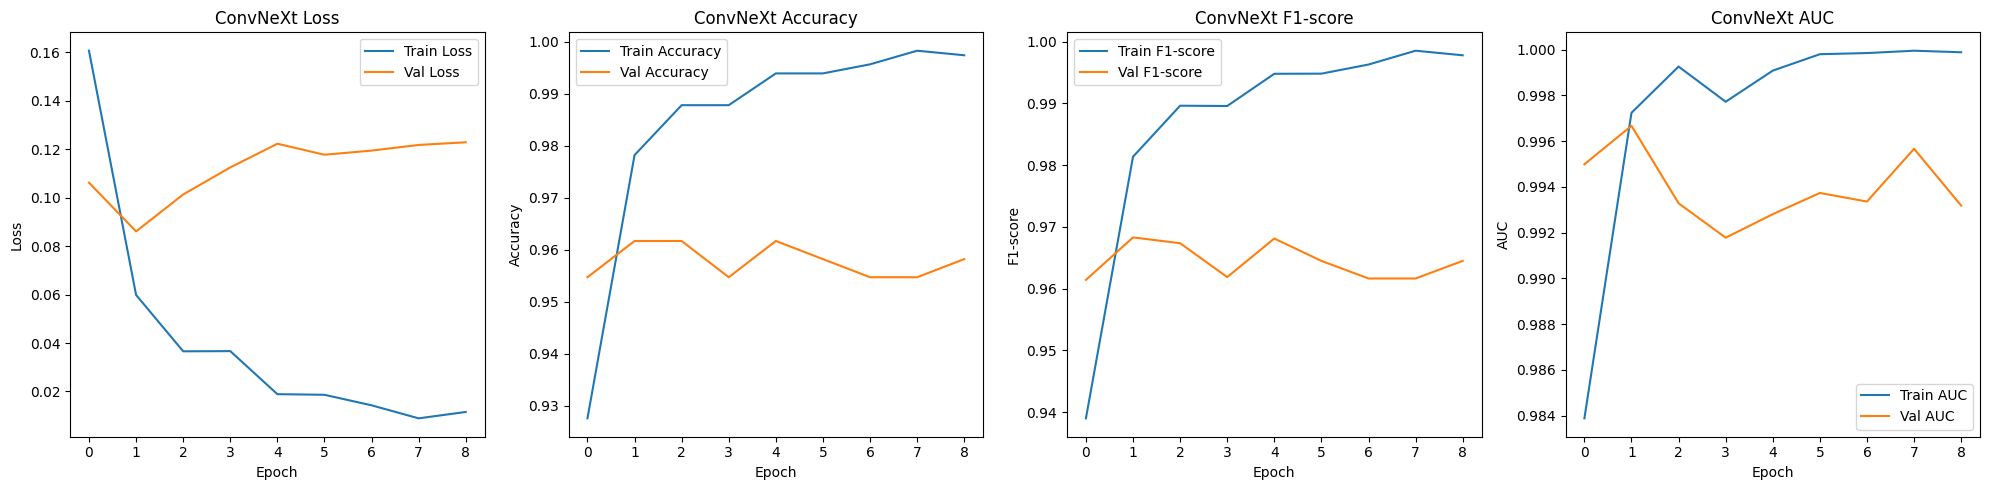


Loading best ConvNeXtSmall model for final validation evaluation...
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 922ms/step

--- Final Validation Set Performance (Best ConvNeXtSmall Model) ---
Accuracy: 0.9617
F1-Score: 0.9683
AUC: 0.9967

Classification Report (Validation - ConvNeXtSmall):
              precision    recall  f1-score   support

 Non-Mitosis       0.99      0.92      0.95       118
     Mitosis       0.94      0.99      0.97       169

    accuracy                           0.96       287
   macro avg       0.97      0.95      0.96       287
weighted avg       0.96      0.96      0.96       287


Confusion Matrix (Validation - ConvNeXtSmall):


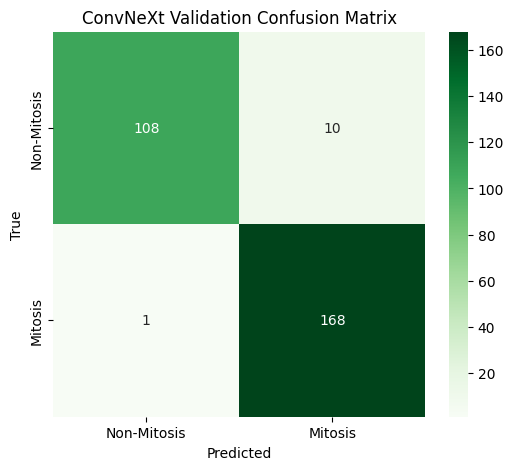


Predicting on test set with ConvNeXtSmall...


Predicting on test batches: 100%|██████████| 42/42 [00:31<00:00,  1.32it/s]

Total predictions made for test set: 1337
Generating submission file for ConvNeXtSmall...
ERROR generating submission file: 'Image'


In [ ]:
import json
import os
import math
import numpy as np
import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ConvNeXtSmall # The model we want to test
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW # Or Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# --- Configuration & Paths (Updated for Colab) ---
TRAIN_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
TEST_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_test/"
SUBMISSION_TEMPLATE_PATH = "/content/glioma_data/archive/Submission_template.csv"
MODEL_SAVE_PATH_CONVNEXT = "/content/best_convnext_model.keras" # Keras model format
SUBMISSION_FILE_PATH_CONVNEXT = "/content/submission_convnext.csv"


DATASET_MEAN_RGB_0_1 = [0.588, 0.374, 0.619] # For 0-1 scaled images
DATASET_STD_RGB_0_1 = [0.168, 0.153, 0.127]

IMAGE_SIZE = 224 # ConvNeXtSmall is often trained on 224x224
BATCH_SIZE = 32
NUM_EPOCHS = 20 # Start with this, adjust as needed
LEARNING_RATE = 1e-4 # Initial learning rate
WEIGHT_DECAY = 1e-5 # For AdamW

# --- Helper Functions (same as before for data parsing) ---
def get_bbox(points, img_width, img_height):
    if not points: return None
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    if not xs or not ys: return None # Should not happen if points is not empty

    min_x = max(0, int(math.floor(min(xs))))
    max_x = min(img_width, int(math.ceil(max(xs))))
    min_y = max(0, int(math.floor(min(ys))))
    max_y = min(img_height, int(math.ceil(max(ys))))

    if min_x >= max_x or min_y >= max_y: return None
    return [min_x, min_y, max_x, max_y]

def parse_json_data(json_path, data_dir, is_test=False):
    samples = []
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception as e:
        # print(f"Error reading or parsing JSON {json_path}: {e}")
        return samples # Return empty list if JSON is malformed

    image_filename = os.path.basename(json_path).replace('.json', '.jpg')
    image_path = os.path.join(data_dir, image_filename)

    if not os.path.exists(image_path):
        # print(f"Image file not found: {image_path}")
        return samples

    try:
        with Image.open(image_path) as img:
            img_width, img_height = img.size
    except Exception as e:
        # print(f"Error opening image {image_path}: {e}")
        return samples

    for shape in data.get('shapes', []): # Use .get for safety
        label_or_id = shape.get('label')
        points = shape.get('points')
        if label_or_id is None or points is None:
            continue # Skip shape if essential info is missing

        bbox = get_bbox(points, img_width, img_height)
        if bbox:
            if is_test:
                # In test mode, label_or_id is the ROI identifier (e.g., "roi_0")
                samples.append((image_path, bbox, label_or_id))
            else:
                # In training mode, convert label to binary
                label = 1 if label_or_id == 'Mitosis' else 0
                samples.append((image_path, bbox, label))
    return samples

# --- Keras Data Generator ---
class KerasGliomaDataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, image_size, shuffle=True, is_test=False, augment=False):
        super().__init__() # Call super constructor
        self.samples = samples
        self.batch_size = batch_size
        self.image_size = (image_size, image_size) # tuple (height, width)
        self.shuffle = shuffle
        self.is_test = is_test
        self.augment = augment
        self.image_cache = {}
        self.indexes = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return math.ceil(len(self.samples) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_and_preprocess_image(self, image_path, bbox):
        # Load full image from cache or disk
        if image_path not in self.image_cache:
            try:
                img_pil = Image.open(image_path).convert('RGB')
                self.image_cache[image_path] = img_pil # Cache the full PIL image
            except Exception as e:
                # print(f"Warning: Could not load image {image_path}: {e}")
                return None
        else:
            img_pil = self.image_cache[image_path]

        # Crop and resize ROI
        try:
            cropped_roi = img_pil.crop(bbox)
            if cropped_roi.width == 0 or cropped_roi.height == 0:
                # print(f"Warning: Zero-size crop for {image_path} with bbox {bbox}")
                return None
            # Resize to target image_size, using LANCZOS for antialiasing
            resized_roi = cropped_roi.resize((self.image_size[1], self.image_size[0]), Image.Resampling.LANCZOS)
            img_array = keras.utils.img_to_array(resized_roi) # Converts to float32, scales to [0,255]
            return img_array
        except Exception as e:
            # print(f"Warning: Could not process/resize ROI from {image_path}: {e}")
            return None

    def _augment_image(self, image_np_array):
        image_tensor = tf.convert_to_tensor(image_np_array, dtype=tf.float32)
        if tf.random.uniform(()) > 0.5:
            image_tensor = tf.image.flip_left_right(image_tensor)
        if tf.random.uniform(()) > 0.5:
            image_tensor = tf.image.flip_up_down(image_tensor)
        # Example: Random rotation (0, 90, 180, 270 degrees)
        # k_rot = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
        # image_tensor = tf.image.rot90(image_tensor, k=k_rot)
        # Example: Brightness adjustment
        # image_tensor = tf.image.random_brightness(image_tensor, max_delta=0.1) # delta between -0.1 and 0.1
        return image_tensor.numpy()

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_samples_info = [self.samples[k] for k in batch_indexes]

        images_batch = []
        labels_batch = [] # For train/val
        info_batch = []   # For test (image_id, roi_id)

        for image_path, bbox, label_or_id in batch_samples_info:
            img_array = self._load_and_preprocess_image(image_path, bbox)
            if img_array is None:
                continue # Skip this sample if loading/preprocessing failed

            if self.augment and not self.is_test:
                img_array = self._augment_image(img_array)

            images_batch.append(img_array)
            if self.is_test:
                image_id = os.path.basename(image_path).split('.')[0] # e.g., "image_0000"
                info_batch.append((image_id, label_or_id)) # label_or_id is roi_id (e.g. "roi_0")
            else:
                labels_batch.append(label_or_id) # label_or_id is 0 or 1


        if not images_batch: # All samples in batch failed

            dummy_shape = (self.batch_size, self.image_size[0], self.image_size[1], 3)
            dummy_images = np.zeros(dummy_shape, dtype=np.float32)
            if self.is_test:
                dummy_info = [("dummy_image_id", "dummy_roi_id")] * self.batch_size
                return dummy_images, dummy_info
            else:
                dummy_labels = np.zeros((self.batch_size, 1), dtype=int)
                return dummy_images, dummy_labels


        final_images_batch = np.array(images_batch, dtype=np.float32)

        if self.is_test:
            return final_images_batch, info_batch
        else:

            final_labels_batch = np.array(labels_batch, dtype=int).reshape(-1, 1)
            return final_images_batch, final_labels_batch


print("Loading and preparing data samples...")
all_train_json_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.json')]
all_test_json_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.json')]

all_training_samples = []
for json_file in tqdm(all_train_json_files, desc="Parsing Train JSONs"):
    all_training_samples.extend(parse_json_data(json_file, TRAIN_DIR, is_test=False))

all_test_samples = []
for json_file in tqdm(all_test_json_files, desc="Parsing Test JSONs"):
    all_test_samples.extend(parse_json_data(json_file, TEST_DIR, is_test=True))

print(f"Total training ROIs found: {len(all_training_samples)}")
print(f"Total test ROIs found: {len(all_test_samples)}")

train_samples, val_samples = [], []
if all_training_samples:
    train_labels_for_split = [s[2] for s in all_training_samples]
    if len(set(train_labels_for_split)) > 1 and len(all_training_samples) >= 2 * 5:
        try:
            train_samples, val_samples = train_test_split(
                all_training_samples,
                test_size=0.2,
                random_state=42,
                stratify=train_labels_for_split
            )
        except ValueError:
            train_samples, val_samples = train_test_split(
                all_training_samples, test_size=0.2, random_state=42
            )
    elif len(all_training_samples) > 0 :
        train_samples, val_samples = train_test_split(
            all_training_samples,
            test_size=0.2,
            random_state=42
        )
    print(f"Train samples: {len(train_samples)}, Validation samples: {len(val_samples)}")
else:
    print("No training samples found. Cannot create train/validation sets.")


train_generator, val_generator = None, None
if train_samples and val_samples:
    train_generator = KerasGliomaDataGenerator(train_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=True, augment=True)
    val_generator = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, augment=False)
    print(f"Train generator created with {len(train_generator)} batches.")
    print(f"Validation generator created with {len(val_generator)} batches.")
else:
    print("Skipping generator creation due to lack of train/val samples.")


# --- Model Definition (ConvNeXtSmall) ---
print("Defining ConvNeXtSmall model...")
def create_convnext_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=1):
    base_model = ConvNeXtSmall(
        include_top=False,
        include_preprocessing=True,
        weights="imagenet",
        input_shape=input_shape
    )


    base_model.trainable = True # Fine-tune the entire model

    inputs = Input(shape=input_shape)

    x = base_model(inputs)

    x = GlobalAveragePooling2D()(x)

    outputs = Dense(num_classes, activation='sigmoid')(x) # Sigmoid for binary classification

    model = Model(inputs, outputs)
    return model

convnext_model = create_convnext_model()
convnext_model.summary()

# --- Compile Model ---
convnext_model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_score'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# --- Callbacks ---
checkpoint = ModelCheckpoint(
    MODEL_SAVE_PATH_CONVNEXT,
    monitor='val_f1_score',
    save_best_only=True,
    mode='max',
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_f1_score',
    factor=0.2,
    patience=3,
    mode='max',
    min_lr=1e-7,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_f1_score',
    patience=7,
    mode='max',
    restore_best_weights=True,
    verbose=1
)

# --- Training ---
history_convnext = None
if train_generator and val_generator and len(train_generator) > 0 and len(val_generator) > 0:
    print("Starting ConvNeXtSmall training...")
    history_convnext = convnext_model.fit(
        train_generator,
        epochs=NUM_EPOCHS,
        validation_data=val_generator,
        callbacks=[checkpoint, reduce_lr, early_stopping]
    )
    print("ConvNeXtSmall training finished.")

    # --- Plot Training History ---
    plt.figure(figsize=(20, 5))

    # Loss
    plt.subplot(1, 4, 1)
    plt.plot(history_convnext.history['loss'], label='Train Loss')
    plt.plot(history_convnext.history['val_loss'], label='Val Loss')
    plt.title('ConvNeXt Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 4, 2)
    plt.plot(history_convnext.history['accuracy'], label='Train Accuracy')
    plt.plot(history_convnext.history['val_accuracy'], label='Val Accuracy')
    plt.title('ConvNeXt Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # F1-score
    plt.subplot(1, 4, 3)
    plt.plot(history_convnext.history['f1_score'], label='Train F1-score')
    plt.plot(history_convnext.history['val_f1_score'], label='Val F1-score')
    plt.title('ConvNeXt F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()

    # AUC
    plt.subplot(1, 4, 4)
    plt.plot(history_convnext.history['auc'], label='Train AUC')
    plt.plot(history_convnext.history['val_auc'], label='Val AUC')
    plt.title('ConvNeXt AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # --- Evaluation on Validation Set with Best Model ---
    print("\nLoading best ConvNeXtSmall model for final validation evaluation...")

    val_generator_eval = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, augment=False)

    if len(val_generator_eval) > 0:
        val_preds_probs = convnext_model.predict(val_generator_eval, verbose=1)
        val_preds_binary = (val_preds_probs > 0.5).astype(int).flatten()

        true_val_labels = []
        for i in range(len(val_generator_eval)):
            _, labels_batch = val_generator_eval[i]
            true_val_labels.extend(labels_batch.flatten())
        true_val_labels = np.array(true_val_labels)[:len(val_preds_binary)]

        if true_val_labels.size > 0 and len(val_preds_binary) == true_val_labels.size:
            final_val_acc = accuracy_score(true_val_labels, val_preds_binary)
            final_val_f1 = f1_score(true_val_labels, val_preds_binary)
            try:
                final_val_auc = roc_auc_score(true_val_labels, val_preds_probs.flatten()[:len(true_val_labels)])
            except ValueError as e:
                print(f"Could not calculate AUC on validation set: {e}")
                final_val_auc = 0.0

            print("\n--- Final Validation Set Performance (Best ConvNeXtSmall Model) ---")
            print(f"Accuracy: {final_val_acc:.4f}")
            print(f"F1-Score: {final_val_f1:.4f}")
            print(f"AUC: {final_val_auc:.4f}")

            print("\nClassification Report (Validation - ConvNeXtSmall):")
            print(classification_report(true_val_labels, val_preds_binary, target_names=['Non-Mitosis', 'Mitosis'], zero_division=0))

            print("\nConfusion Matrix (Validation - ConvNeXtSmall):")
            cm = confusion_matrix(true_val_labels, val_preds_binary)
            plt.figure(figsize=(6,5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Mitosis', 'Mitosis'], yticklabels=['Non-Mitosis', 'Mitosis'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('ConvNeXt Validation Confusion Matrix')
            plt.show()
        else:
            print("Mismatch in prediction and label counts, or no validation data to evaluate.")
    else:
        print("Validation generator is empty. Skipping evaluation.")
else:
    print("Training was skipped or did not complete. Skipping evaluation and plotting.")



if all_test_samples:
    print("\nPredicting on test set with ConvNeXtSmall...")

    if os.path.exists(MODEL_SAVE_PATH_CONVNEXT) and not (history_convnext and early_stopping.restore_best_weights):
        print(f"Loading best weights from {MODEL_SAVE_PATH_CONVNEXT} for test prediction.")
        convnext_model.load_weights(MODEL_SAVE_PATH_CONVNEXT)

    test_generator = KerasGliomaDataGenerator(all_test_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, is_test=True, augment=False)

    predictions_dict_convnext = {}
    if len(test_generator) > 0:
        all_test_preds_probs_list = []
        all_test_info_list = []

        for i in tqdm(range(len(test_generator)), desc="Predicting on test batches"):
            batch_images, batch_info = test_generator[i]

            if not batch_images.size or (isinstance(batch_info, list) and batch_info and batch_info[0][0] == "dummy_image_id"):
                continue # Skip dummy batches

            batch_preds_probs = convnext_model.predict(batch_images, verbose=0) # Get probabilities

            all_test_preds_probs_list.extend(batch_preds_probs.flatten().tolist())
            all_test_info_list.extend(batch_info)

        if all_test_preds_probs_list:
            all_test_preds_binary = (np.array(all_test_preds_probs_list) > 0.5).astype(int)

            for i in range(len(all_test_info_list)):
                image_id, roi_id = all_test_info_list[i]
                predictions_dict_convnext[(image_id, roi_id)] = all_test_preds_binary[i]

            print(f"Total predictions made for test set: {len(predictions_dict_convnext)}")

            # --- Generate Submission File ---
            print("Generating submission file for ConvNeXtSmall...")
            try:
                submission_df = pd.read_csv(SUBMISSION_TEMPLATE_PATH)

                output_predictions = []
                for index, row in submission_df.iterrows():
                    image_id_template = row['Image']
                    roi_id_template = str(row['ROI']) # Ensure ROI is string, as it comes from JSON label

                    pred = predictions_dict_convnext.get((image_id_template, roi_id_template), 0) # Default to 0 (Non-Mitosis) if not found
                    output_predictions.append(pred)

                submission_df['Prediction'] = output_predictions
                submission_df.to_csv(SUBMISSION_FILE_PATH_CONVNEXT, index=False)
                print(f"Submission file saved to {SUBMISSION_FILE_PATH_CONVNEXT}")
                print("Sample of submission file:")
                print(submission_df.head())
                print(f"\nValue counts in submission predictions:\n{submission_df['Prediction'].value_counts(dropna=False)}")

            except FileNotFoundError:
                print(f"ERROR: Submission template not found at {SUBMISSION_TEMPLATE_PATH}")
            except Exception as e:
                print(f"ERROR generating submission file: {e}")
        else:
            print("No predictions were generated for the test set.")
    else:
        print("Test generator is empty. Skipping prediction.")
else:
    print("No test samples found. Skipping prediction on test set.")

In [ ]:
# --- Prediction on Test Set & Submission File Generation ---
print("\nPredicting on test set with ConvNeXtSmall...")
test_generator = KerasGliomaDataGenerator(all_test_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, is_test=True)

# Modified prediction approach
predictions_dict_convnext = {}
current_batch_start_idx = 0

for i in tqdm(range(len(test_generator)), desc="Predicting on test batches"):
    # Get batch data
    batch_images, batch_info = test_generator[i]

    # Skip if dummy data (from padding)
    if isinstance(batch_info[0][0], str) and batch_info[0][0] == "dummy_id":
        continue

    # Predict
    batch_preds = convnext_model.predict(batch_images, verbose=0)
    batch_preds_binary = (batch_preds > 0.5).astype(int).flatten()

    # Map predictions to image_id and roi_id
    for j in range(len(batch_info)):
        image_id, roi_id = batch_info[j]
        predictions_dict_convnext[(image_id, roi_id)] = batch_preds_binary[j]

print(f"\nFound {len(predictions_dict_convnext)} predictions for the test set (ConvNeXt).")

# Create submission file
submission_df_convnext = pd.read_csv(SUBMISSION_TEMPLATE_PATH)
print(f"Submission template has {len(submission_df_convnext)} rows.")

submission_df_convnext['Prediction'] = submission_df_convnext.apply(
    lambda row: predictions_dict_convnext.get((row['Image ID'], row['Label ID']), 0),
    axis=1
)

found_in_dict_count_convnext = sum(
    1 for _, row in submission_df_convnext.iterrows()
    if (row['Image ID'], row['Label ID']) in predictions_dict_convnext
)
print(f"Number of rows in submission template matched with ConvNeXt predictions: {found_in_dict_count_convnext}")

submission_df_convnext.to_csv(SUBMISSION_FILE_PATH_CONVNEXT, index=False)
print(f"ConvNeXt submission file saved to {SUBMISSION_FILE_PATH_CONVNEXT}")
print(f"Number of Mitosis predictions in ConvNeXt submission: {submission_df_convnext['Prediction'].sum()} out of {len(submission_df_convnext)}")


Predicting on test set with ConvNeXtSmall...


Predicting on test batches: 100%|██████████| 42/42 [00:43<00:00,  1.03s/it]


Found 1337 predictions for the test set (ConvNeXt).
Submission template has 1443 rows.
Number of rows in submission template matched with ConvNeXt predictions: 1109
ConvNeXt submission file saved to /content/submission_convnext.csv
Number of Mitosis predictions in ConvNeXt submission: 157 out of 1443


# **EfficientNetV2B0**

Loading and preparing data samples...


Parsing Test JSONs: 100%|██████████| 200/200 [00:00<00:00, 671.52it/s]


Total training ROIs found: 1433
Total test ROIs found: 1337
Train samples: 1146, Validation samples: 287
Defining EfficientNetV2B0 model...
24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,920,593 (22.59 MB)

 Trainable params: 5,859,985 (22.35 MB)

 Non-trainable params: 60,608 (236.75 KB)

Starting EfficientNetV2B0 training...
Epoch 1/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7199 - f1_score: 0.7613 - loss: 0.5564
Epoch 1: val_f1_score improved from -inf to 0.89067, saving model to /content/best_efficientnetv2_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.7231 - f1_score: 0.7640 - loss: 0.5526 - val_accuracy: 0.8571 - val_f1_score: 0.8907 - val_loss: 0.4122 - learning_rate: 1.0000e-04
Epoch 2/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.9430 - f1_score: 0.9511 - loss: 0.1542
Epoch 2: val_f1_score improved from 0.89067 to 0.95238, saving model to /content/best_efficientnetv2_model.keras
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 286ms/step - accuracy: 0.9432 - f1_score: 0.9514 - loss: 0.1535 - val_accuracy: 0.9443 - val_f1_score: 0.9524 - val_loss: 0.1163 - learning_rate: 1.0000e-04
Epoch 3/25
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9487 - f1_score: 0.9570 - loss: 0.1238
Epoch 3: val_f1_score improved from 0.95238 to 0.9671

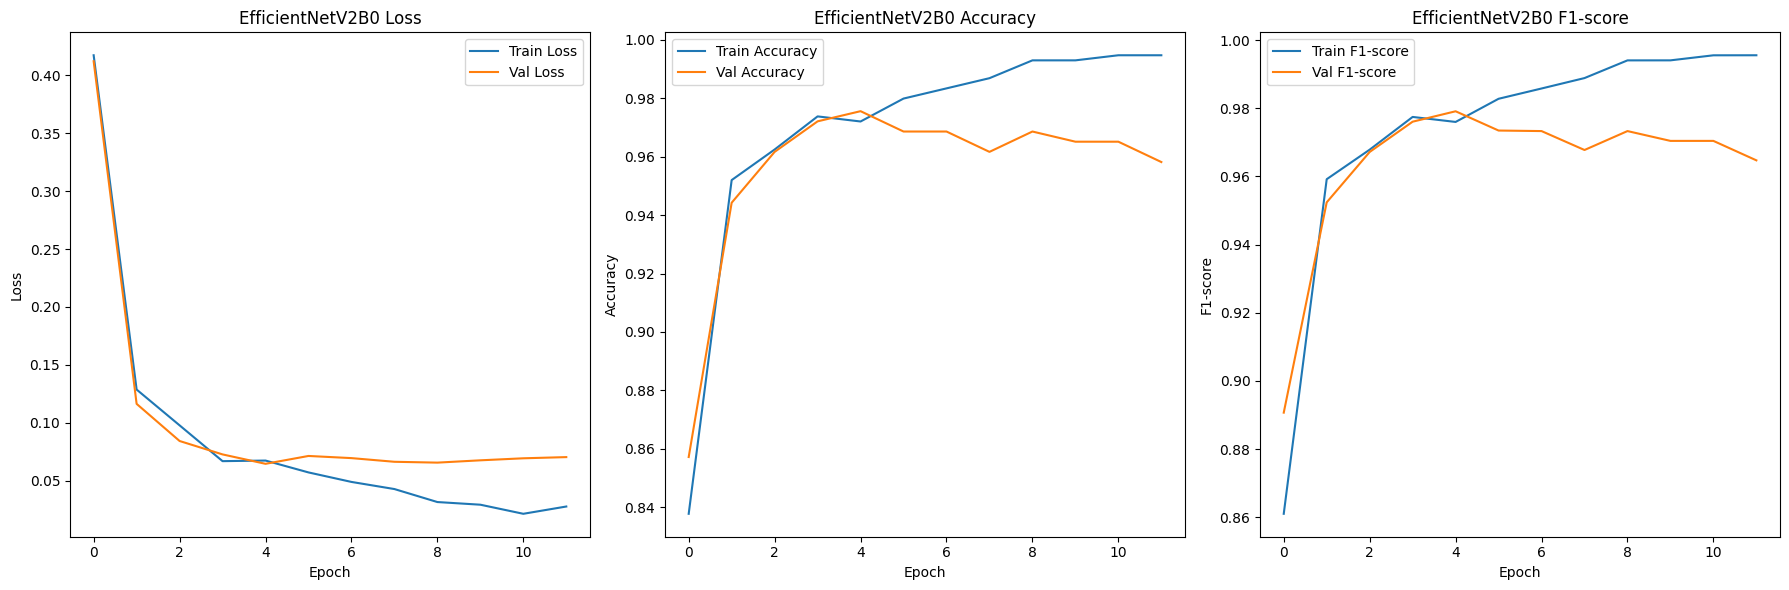


Loading best EfficientNetV2B0 model for final validation evaluation...
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 865ms/step

--- Final Validation Set Performance (Best EfficientNetV2B0 Model) ---
Accuracy: 0.9756
F1-Score: 0.9791
AUC: 0.9973

Classification Report (Validation - EfficientNetV2B0):
              precision    recall  f1-score   support

 Non-Mitosis       0.96      0.98      0.97       118
     Mitosis       0.99      0.97      0.98       169

    accuracy                           0.98       287
   macro avg       0.97      0.98      0.97       287
weighted avg       0.98      0.98      0.98       287


Confusion Matrix (Validation - EfficientNetV2B0):


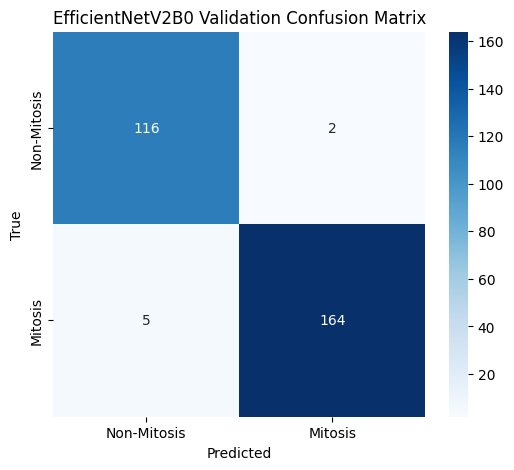


Predicting on test set with EfficientNetV2B0...
Loading best weights from /content/best_efficientnetv2_model.keras for test prediction.
42/42 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step

Found 1337 predictions for the test set (EfficientNetV2B0).
Submission template has 1443 rows.
Number of rows in submission template matched with EfficientNetV2B0 predictions: 1109
EfficientNetV2B0 submission file saved to /content/submission_efficientnetv2.csv
Number of Mitosis predictions in EfficientNetV2B0 submission: 156 out of 1443


In [ ]:
import json
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
# Import EfficientNetV2B0 (or other variants like EfficientNetV2S, EfficientNetV2M)
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW # Or Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

# --- Configuration & Paths (Updated for EfficientNetV2) ---
TRAIN_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
TEST_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_test/"
SUBMISSION_TEMPLATE_PATH = "/content/glioma_data/archive/Submission_template.csv"
MODEL_SAVE_PATH_EFFICIENTNET = "/content/best_efficientnetv2_model.keras" # Keras model format
SUBMISSION_FILE_PATH_EFFICIENTNET = "/content/submission_efficientnetv2.csv"

# --- Normalization: EfficientNetV2 (like ConvNeXt) has its own preprocessing ---
# We will use the built-in preprocessing layer if include_preprocessing=True.

IMAGE_SIZE = 224 # EfficientNetV2B0 default is 224x224. Other variants might prefer larger.
BATCH_SIZE = 32
NUM_EPOCHS = 25 # EfficientNets can sometimes benefit from slightly more epochs
LEARNING_RATE = 1e-4 # Initial learning rate (good starting point)
WEIGHT_DECAY = 1e-5 # For AdamW

# --- Helper Functions (same as before for data parsing) ---
def get_bbox(points, img_width, img_height):
    if not points: return None
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    if not xs or not ys: return None
    min_x = max(0, int(math.floor(min(xs))))
    max_x = min(img_width, int(math.ceil(max(xs))))
    min_y = max(0, int(math.floor(min(ys))))
    max_y = min(img_height, int(math.ceil(max(ys))))
    if min_x >= max_x or min_y >= max_y: return None
    return [min_x, min_y, max_x, max_y]

def parse_json_data(json_path, data_dir, is_test=False):
    samples = []
    with open(json_path, 'r') as f:
        data = json.load(f)
    image_filename = os.path.basename(json_path).replace('.json', '.jpg')
    image_path = os.path.join(data_dir, image_filename)
    if not os.path.exists(image_path): return samples
    try:
        with Image.open(image_path) as img: img_width, img_height = img.size
    except Exception: return samples

    for shape in data['shapes']:
        label_or_id = shape['label']
        bbox = get_bbox(shape['points'], img_width, img_height)
        if bbox:
            if is_test:
                samples.append((image_path, bbox, label_or_id))
            else:
                label = 1 if label_or_id == 'Mitosis' else 0
                samples.append((image_path, bbox, label))
    return samples

# --- Keras Data Generator (Using the improved version from previous solution) ---
class KerasGliomaDataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, image_size, shuffle=True, is_test=False, augment=False):
        super().__init__()
        self.samples = samples
        self.batch_size = batch_size
        self.image_size = (image_size, image_size)
        self.shuffle = shuffle
        self.is_test = is_test
        self.augment = augment
        self.image_cache = {}
        self.indexes = np.arange(len(self.samples))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return math.ceil(len(self.samples) / self.batch_size)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def _load_and_preprocess_image(self, image_path, bbox):
        if image_path not in self.image_cache:
            try:
                img_pil = Image.open(image_path).convert('RGB')
                self.image_cache[image_path] = img_pil
            except Exception:
                return None
        else:
            img_pil = self.image_cache[image_path]

        try:
            cropped_roi = img_pil.crop(bbox)
            if cropped_roi.width == 0 or cropped_roi.height == 0:
                return None
            resized_roi = cropped_roi.resize((self.image_size[1], self.image_size[0]), Image.Resampling.LANCZOS)
            img_array = keras.utils.img_to_array(resized_roi)
            return img_array
        except Exception:
            return None

    def _augment_image(self, image_np_array):
        image_tensor = tf.convert_to_tensor(image_np_array, dtype=tf.float32)
        if tf.random.uniform(()) > 0.5:
            image_tensor = tf.image.flip_left_right(image_tensor)
        if tf.random.uniform(()) > 0.5:
            image_tensor = tf.image.flip_up_down(image_tensor)

        return image_tensor.numpy()

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        images_batch = []
        labels_batch = []

        for i in range(len(batch_indexes)):
            original_sample_index = batch_indexes[i]
            image_path, bbox, label_or_id = self.samples[original_sample_index]

            img_array = self._load_and_preprocess_image(image_path, bbox)

            if img_array is None:
                dummy_img_shape = (self.image_size[0], self.image_size[1], 3)
                img_array = np.zeros(dummy_img_shape, dtype=np.float32)

            if self.augment and not self.is_test:
                img_array = self._augment_image(img_array)

            images_batch.append(img_array)

            if not self.is_test:
                labels_batch.append(label_or_id)

        images_np_array = np.array(images_batch)

        if self.is_test:
            return images_np_array
        else:
            labels_np_array = np.array(labels_batch).reshape(-1, 1)
            return images_np_array, labels_np_array


print("Loading and preparing data samples...")
all_train_json_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.json')]
all_test_json_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.json')]

all_training_samples = []
for json_file in tqdm(all_train_json_files, desc="Parsing Train JSONs"):
    all_training_samples.extend(parse_json_data(json_file, TRAIN_DIR, is_test=False))

all_test_samples = []
for json_file in tqdm(all_test_json_files, desc="Parsing Test JSONs"):
    all_test_samples.extend(parse_json_data(json_file, TEST_DIR, is_test=True))

print(f"Total training ROIs found: {len(all_training_samples)}")
print(f"Total test ROIs found: {len(all_test_samples)}")

if not all_training_samples:
    raise ValueError("No training samples found. Please check TRAIN_DIR and JSON parsing.")

train_labels_for_split = [s[2] for s in all_training_samples]
if len(set(train_labels_for_split)) > 1:
    train_samples, val_samples = train_test_split(
        all_training_samples, test_size=0.2, random_state=42, stratify=train_labels_for_split)
else:
    print("Warning: Only one class found in training data, or no data. Stratification not possible.")
    train_samples, val_samples = train_test_split(all_training_samples, test_size=0.2, random_state=42)
print(f"Train samples: {len(train_samples)}, Validation samples: {len(val_samples)}")

if not train_samples:
    raise ValueError("No samples in the training set after split. Check data and split.")
if not val_samples:
    print("Warning: No samples in the validation set after split. Validation will be skipped or may fail.")

train_generator = KerasGliomaDataGenerator(train_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=True, augment=True)
val_generator = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False) if val_samples else None


# --- Model Definition (EfficientNetV2B0) ---
print("Defining EfficientNetV2B0 model...")
def create_efficientnetv2_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=1, dropout_rate=0.3):

    base_model = EfficientNetV2B0( # Or EfficientNetV2S, EfficientNetV2M etc.
        include_top=False,
        include_preprocessing=True, # Handles normalization internally
        weights="imagenet",
        input_shape=input_shape,
        # drop_connect_rate=0.2 # Optional: EfficientNet specific regularization, can help
    )


    base_model.trainable = True



    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=base_model.trainable) # Pass training status
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x) # Add dropout for regularization

    outputs = Dense(num_classes, activation='sigmoid')(x) # Sigmoid for binary classification

    model = Model(inputs, outputs)
    return model

efficientnet_model = create_efficientnetv2_model()
efficientnet_model.summary()

# --- Compile Model ---
efficientnet_model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_score')]
)

# --- Callbacks ---
checkpoint_effnet = ModelCheckpoint(
    MODEL_SAVE_PATH_EFFICIENTNET, monitor='val_f1_score', save_best_only=True, mode='max', verbose=1)
reduce_lr_effnet = ReduceLROnPlateau(
    monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-7, verbose=1) # Lower min_lr
early_stopping_effnet = EarlyStopping(
    monitor='val_f1_score', patience=7, mode='max', restore_best_weights=True, verbose=1)

# --- Training ---
print("Starting EfficientNetV2B0 training...")
history_efficientnet = efficientnet_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator if val_generator else None, # Handle case where val_generator might be None
    callbacks=[checkpoint_effnet, reduce_lr_effnet, early_stopping_effnet]
)
print("EfficientNetV2B0 training finished.")

# --- Plot Training History ---
if history_efficientnet and history_efficientnet.history:
    plt.figure(figsize=(18, 6))
    # Loss
    plt.subplot(1, 3, 1)
    plt.plot(history_efficientnet.history['loss'], label='Train Loss')
    if 'val_loss' in history_efficientnet.history:
        plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
    plt.title('EfficientNetV2B0 Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    # Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history_efficientnet.history:
        plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
    plt.title('EfficientNetV2B0 Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    # F1-score
    plt.subplot(1, 3, 3)
    plt.plot(history_efficientnet.history['f1_score'], label='Train F1-score')
    if 'val_f1_score' in history_efficientnet.history:
        plt.plot(history_efficientnet.history['val_f1_score'], label='Val F1-score')
    plt.title('EfficientNetV2B0 F1-score')
    plt.xlabel('Epoch')
    plt.ylabel('F1-score')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No training history to plot for EfficientNetV2B0.")


# --- Evaluation on Validation Set with Best Model ---
if val_samples: # Only evaluate if there's validation data
    print("\nLoading best EfficientNetV2B0 model for final validation evaluation...")
    if os.path.exists(MODEL_SAVE_PATH_EFFICIENTNET):
        efficientnet_model.load_weights(MODEL_SAVE_PATH_EFFICIENTNET)
    else:
        print(f"Warning: Model file {MODEL_SAVE_PATH_EFFICIENTNET} not found. Using current model weights.")


    val_generator_eval = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False)
    val_preds_probs = efficientnet_model.predict(val_generator_eval, verbose=1)
    val_preds_binary = (val_preds_probs > 0.5).astype(int).flatten()

    true_val_labels = []
    for i in range(len(val_generator_eval)):
        _, labels_batch = val_generator_eval[i]
        true_val_labels.extend(labels_batch.flatten()) # Ensure labels are flattened
    true_val_labels = np.array(true_val_labels)[:len(val_preds_binary)]

    if true_val_labels.size > 0:
        final_val_acc = accuracy_score(true_val_labels, val_preds_binary)
        final_val_f1 = f1_score(true_val_labels, val_preds_binary)
        try:
            final_val_auc = roc_auc_score(true_val_labels, val_preds_probs.flatten()[:len(true_val_labels)])
        except ValueError as e:
            print(f"AUC calculation error: {e}. Setting AUC to 0.0. Check if only one class present in true labels or predictions.")
            final_val_auc = 0.0

        print("\n--- Final Validation Set Performance (Best EfficientNetV2B0 Model) ---")
        print(f"Accuracy: {final_val_acc:.4f}")
        print(f"F1-Score: {final_val_f1:.4f}")
        print(f"AUC: {final_val_auc:.4f}")

        print("\nClassification Report (Validation - EfficientNetV2B0):")
        print(classification_report(true_val_labels, val_preds_binary, target_names=['Non-Mitosis', 'Mitosis'], zero_division=0))

        print("\nConfusion Matrix (Validation - EfficientNetV2B0):")
        cm = confusion_matrix(true_val_labels, val_preds_binary)
        plt.figure(figsize=(6,5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Mitosis', 'Mitosis'], yticklabels=['Non-Mitosis', 'Mitosis'])
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('EfficientNetV2B0 Validation Confusion Matrix')
        plt.show()
    else:
        print("No data in validation set to evaluate for EfficientNetV2B0.")
else:
    print("Skipping validation set evaluation as no validation samples were available.")


# --- Prediction on Test Set & Submission File Generation ---
print("\nPredicting on test set with EfficientNetV2B0...")
if not all_test_samples:
    print("No test samples found. Skipping prediction and submission.")
else:
    test_generator = KerasGliomaDataGenerator(all_test_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, is_test=True)

    if os.path.exists(MODEL_SAVE_PATH_EFFICIENTNET): # Load best weights if they exist
        print(f"Loading best weights from {MODEL_SAVE_PATH_EFFICIENTNET} for test prediction.")
        efficientnet_model.load_weights(MODEL_SAVE_PATH_EFFICIENTNET)
    else:
        print(f"Warning: Model file {MODEL_SAVE_PATH_EFFICIENTNET} not found. Using current (potentially last epoch's) model weights for test set.")

    test_preds_all_probs = efficientnet_model.predict(test_generator, verbose=1)
    test_preds_all_binary = (test_preds_all_probs > 0.5).astype(int).flatten()

    if len(test_preds_all_binary) != len(all_test_samples):
        print(f"CRITICAL WARNING: Mismatch in prediction count for test set!")
        print(f"Predictions: {len(test_preds_all_binary)}, Test Samples: {len(all_test_samples)}")
        print("Mapping predictions to submission file might be incorrect.")

    predictions_dict_efficientnet = {}
    for i, sample_info in enumerate(all_test_samples):
        image_path, _, roi_id = sample_info
        image_id_from_path = os.path.basename(image_path).split('.')[0]

        if i < len(test_preds_all_binary):
            prediction_value = test_preds_all_binary[i]
            predictions_dict_efficientnet[(image_id_from_path, roi_id)] = prediction_value
        else:
            print(f"Warning: No prediction for test sample index {i}. Assigning default 0.")
            predictions_dict_efficientnet[(image_id_from_path, roi_id)] = 0 # Default for safety


    print(f"\nFound {len(predictions_dict_efficientnet)} predictions for the test set (EfficientNetV2B0).")

    submission_df_efficientnet = pd.read_csv(SUBMISSION_TEMPLATE_PATH)
    print(f"Submission template has {len(submission_df_efficientnet)} rows.")

    submission_df_efficientnet['Prediction'] = submission_df_efficientnet.apply(
        lambda row: predictions_dict_efficientnet.get((row['Image ID'], row['Label ID']), 0),
        axis=1
    )

    found_in_dict_count_efficientnet = sum(
        1 for _, row in submission_df_efficientnet.iterrows()
        if (row['Image ID'], row['Label ID']) in predictions_dict_efficientnet
    )
    print(f"Number of rows in submission template matched with EfficientNetV2B0 predictions: {found_in_dict_count_efficientnet}")

    submission_df_efficientnet.to_csv(SUBMISSION_FILE_PATH_EFFICIENTNET, index=False)
    print(f"EfficientNetV2B0 submission file saved to {SUBMISSION_FILE_PATH_EFFICIENTNET}")
    if len(submission_df_efficientnet) > 0:
        print(f"Number of Mitosis predictions in EfficientNetV2B0 submission: {submission_df_efficientnet['Prediction'].sum()} out of {len(submission_df_efficientnet)}")
    else:
        print("Submission DataFrame for EfficientNetV2B0 is empty.")

# from google.colab import files
# files.download(SUBMISSION_FILE_PATH_EFFICIENTNET)
# files.download(MODEL_SAVE_PATH_EFFICIENTNET)

# **ResNet101V2**

Loading and preparing data samples...


Parsing Test JSONs: 100%|██████████| 200/200 [00:00<00:00, 1077.41it/s]


Total training ROIs found: 1433
Total test ROIs found: 1337
Train samples: 1146, Validation samples: 287
Defining ResNet101V2 model...
Note: Using ResNet101V2 as a powerful ResNet variant. True ResNeXt101 is not standard in tf.keras.applications.
171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ preprocessing[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r

 Total params: 42,628,609 (162.62 MB)

 Trainable params: 42,530,945 (162.24 MB)

 Non-trainable params: 97,664 (381.50 KB)

Starting ResNet101V2 training...
Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 792ms/step - accuracy: 0.8337 - f1_score: 0.8628 - loss: 0.3591
Epoch 1: val_f1_score improved from -inf to 0.93913, saving model to /content/best_resnet101v2_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8346 - f1_score: 0.8635 - loss: 0.3572 - val_accuracy: 0.9268 - val_f1_score: 0.9391 - val_loss: 0.2746 - learning_rate: 1.0000e-04
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9625 - f1_score: 0.9673 - loss: 0.0955
Epoch 2: val_f1_score improved from 0.93913 to 0.95726, saving model to /content/best_resnet101v2_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 55s 401ms/step - accuracy: 0.9624 - f1_score: 0.9673 - loss: 0.0958 - val_accuracy: 0.9477 - val_f1_score: 0.9573 - val_loss: 0.1795 - learning_rate: 1.0000e-04
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9732 - f1_score: 0.9772 - loss: 0.0778
Epoch 3: val_f1_score improved from 0.95726 to 0.97329, savin

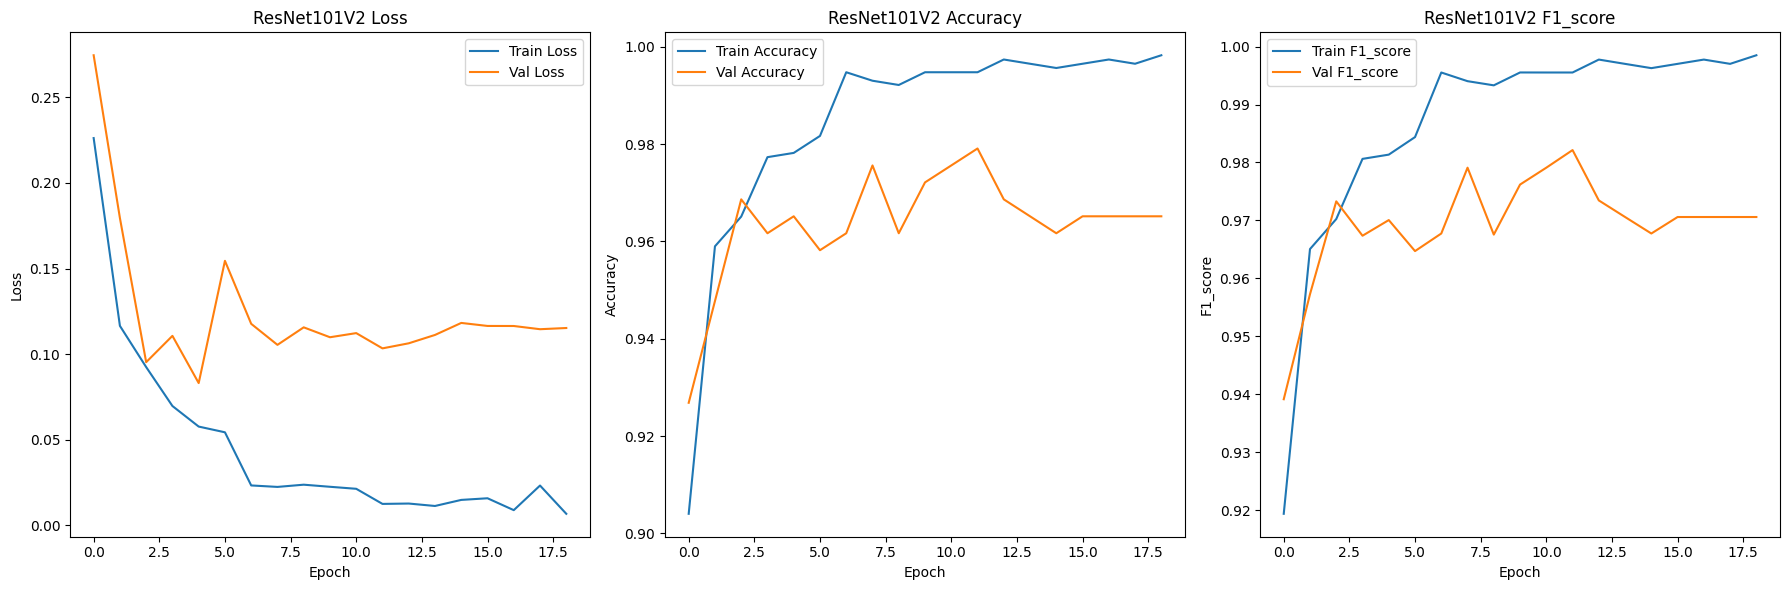


Loading best ResNet101V2 model for final validation evaluation...
18/18 ━━━━━━━━━━━━━━━━━━━━ 14s 442ms/step

--- Final Validation Set Performance (Best ResNet101V2 Model) ---
Accuracy: 0.9791
F1-Score: 0.9821
AUC: 0.9928

Classification Report (Validation - ResNet101V2):
              precision    recall  f1-score   support

 Non-Mitosis       0.97      0.98      0.97       118
     Mitosis       0.99      0.98      0.98       169

    accuracy                           0.98       287
   macro avg       0.98      0.98      0.98       287
weighted avg       0.98      0.98      0.98       287



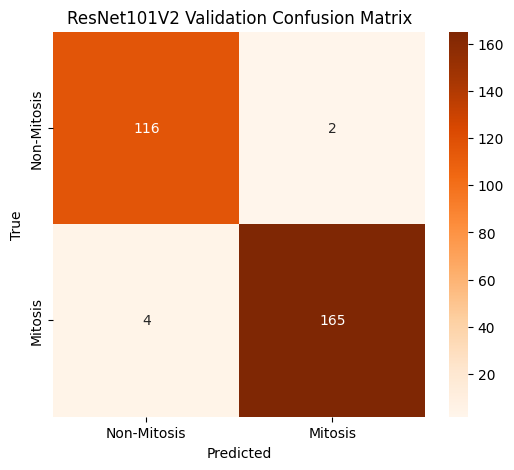


Predicting on test set with ResNet101V2...
Loading best weights from /content/best_resnet101v2_model.keras for test prediction.
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 164ms/step

Found 1337 predictions for the test set (ResNet101V2).
Submission template has 1443 rows.
Rows in submission template matched with ResNet101V2 predictions: 1109
ResNet101V2 submission file saved to /content/submission_resnet101v2.csv
Mitosis predictions in ResNet101V2 submission: 158 out of 1443


In [ ]:
import json
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

# Import ResNet101V2 and its preprocessing function
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_v2_preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

# --- Configuration & Paths (Updated for ResNet101V2) ---
TRAIN_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
TEST_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_test/"
SUBMISSION_TEMPLATE_PATH = "/content/glioma_data/archive/Submission_template.csv"
MODEL_SAVE_PATH_RESNET = "/content/best_resnet101v2_model.keras" # Using ResNet101V2
SUBMISSION_FILE_PATH_RESNET = "/content/submission_resnet101v2.csv"


IMAGE_SIZE = 224
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4 # Good starting point for fine-tuning
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.3

# --- Helper Functions (same as before) ---
def get_bbox(points, img_width, img_height):
    if not points: return None
    xs = [p[0] for p in points]; ys = [p[1] for p in points]
    if not xs or not ys: return None
    min_x = max(0, int(math.floor(min(xs)))); max_x = min(img_width, int(math.ceil(max(xs))))
    min_y = max(0, int(math.floor(min(ys)))); max_y = min(img_height, int(math.ceil(max(ys))))
    if min_x >= max_x or min_y >= max_y: return None
    return [min_x, min_y, max_x, max_y]

def parse_json_data(json_path, data_dir, is_test=False):
    samples = []
    with open(json_path, 'r') as f: data = json.load(f)
    image_filename = os.path.basename(json_path).replace('.json', '.jpg')
    image_path = os.path.join(data_dir, image_filename)
    if not os.path.exists(image_path): return samples
    try:
        with Image.open(image_path) as img: img_width, img_height = img.size
    except Exception: return samples
    for shape in data['shapes']:
        label_or_id = shape['label']
        bbox = get_bbox(shape['points'], img_width, img_height)
        if bbox:
            if is_test: samples.append((image_path, bbox, label_or_id))
            else: samples.append((image_path, bbox, 1 if label_or_id == 'Mitosis' else 0))
    return samples

# --- Keras Data Generator (same as before, preprocessing will be in model) ---
class KerasGliomaDataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, image_size, shuffle=True, is_test=False, augment=False):
        super().__init__()
        self.samples = samples; self.batch_size = batch_size
        self.image_size = (image_size, image_size); self.shuffle = shuffle
        self.is_test = is_test; self.augment = augment
        self.image_cache = {}; self.indexes = np.arange(len(self.samples))
        if self.shuffle: np.random.shuffle(self.indexes)
    def __len__(self): return math.ceil(len(self.samples) / self.batch_size)
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indexes)
    def _load_and_preprocess_image(self, image_path, bbox):
        if image_path not in self.image_cache:
            try: img_pil = Image.open(image_path).convert('RGB'); self.image_cache[image_path] = img_pil
            except Exception: return None
        else: img_pil = self.image_cache[image_path]
        try:
            cropped_roi = img_pil.crop(bbox)
            if cropped_roi.width == 0 or cropped_roi.height == 0: return None
            resized_roi = cropped_roi.resize((self.image_size[1], self.image_size[0]), Image.Resampling.LANCZOS)
            return keras.utils.img_to_array(resized_roi) # Returns 0-255 images
        except Exception: return None
    def _augment_image(self, image_np_array):
        image_tensor = tf.convert_to_tensor(image_np_array, dtype=tf.float32)
        if tf.random.uniform(()) > 0.5: image_tensor = tf.image.flip_left_right(image_tensor)
        if tf.random.uniform(()) > 0.5: image_tensor = tf.image.flip_up_down(image_tensor)
        return image_tensor.numpy()
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        images_batch = []; labels_batch = []
        for i in range(len(batch_indexes)):
            original_sample_index = batch_indexes[i]
            image_path, bbox, label_or_id = self.samples[original_sample_index]
            img_array = self._load_and_preprocess_image(image_path, bbox)
            if img_array is None: img_array = np.zeros((self.image_size[0],self.image_size[1],3),dtype=np.float32)
            if self.augment and not self.is_test: img_array = self._augment_image(img_array)
            images_batch.append(img_array)
            if not self.is_test: labels_batch.append(label_or_id)
        images_np_array = np.array(images_batch)
        if self.is_test: return images_np_array
        else: return images_np_array, np.array(labels_batch).reshape(-1, 1)

# --- Load and Prepare Data ---
print("Loading and preparing data samples...")
all_train_json_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.json')]
all_test_json_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.json')]
all_training_samples = [s for json_file in tqdm(all_train_json_files, desc="Parsing Train JSONs") for s in parse_json_data(json_file, TRAIN_DIR, is_test=False)]
all_test_samples = [s for json_file in tqdm(all_test_json_files, desc="Parsing Test JSONs") for s in parse_json_data(json_file, TEST_DIR, is_test=True)]
print(f"Total training ROIs found: {len(all_training_samples)}")
print(f"Total test ROIs found: {len(all_test_samples)}")

if not all_training_samples: raise ValueError("No training samples found.")
train_labels_for_split = [s[2] for s in all_training_samples]
stratify_labels = train_labels_for_split if len(set(train_labels_for_split)) > 1 else None
train_samples, val_samples = train_test_split(all_training_samples, test_size=0.2, random_state=42, stratify=stratify_labels)
print(f"Train samples: {len(train_samples)}, Validation samples: {len(val_samples)}")

if not train_samples: raise ValueError("No samples in the training set after split.")
train_generator = KerasGliomaDataGenerator(train_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=True, augment=True)
val_generator = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False) if val_samples else None

# --- Model Definition (ResNet101V2) ---
print("Defining ResNet101V2 model...")
print("Note: Using ResNet101V2 as a powerful ResNet variant. True ResNeXt101 is not standard in tf.keras.applications.")
def create_resnet101v2_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=1, dropout_rate=DROPOUT_RATE):
    # Input layer for images in [0, 255] range
    original_inputs = Input(shape=input_shape)

    # Preprocessing layer specific to ResNetV2 (scales to [-1, 1])
    preprocessed_inputs = Lambda(resnet_v2_preprocess_input, name='preprocessing')(original_inputs)

    base_model = ResNet101V2(
        include_top=False,
        weights="imagenet",
        input_tensor=preprocessed_inputs,
    )
    base_model.trainable = True # Full fine-tuning

    # Build the head
    x = base_model.output # Output from the base ResNet101V2 model
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Create the full model
    model = Model(inputs=original_inputs, outputs=outputs)
    return model

resnet_model = create_resnet101v2_model()
resnet_model.summary()

# --- Compile Model ---
resnet_model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_score')]
)

# --- Callbacks ---
checkpoint_resnet = ModelCheckpoint(
    MODEL_SAVE_PATH_RESNET, monitor='val_f1_score', save_best_only=True, mode='max', verbose=1)
reduce_lr_resnet = ReduceLROnPlateau(
    monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-7, verbose=1)
early_stopping_resnet = EarlyStopping(
    monitor='val_f1_score', patience=7, mode='max', restore_best_weights=True, verbose=1)

# --- Training ---
print("Starting ResNet101V2 training...")
history_resnet = resnet_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint_resnet, reduce_lr_resnet, early_stopping_resnet]
)
print("ResNet101V2 training finished.")

# --- Plot Training History ---
if history_resnet and history_resnet.history:
    plt.figure(figsize=(18, 6))
    metrics_to_plot = ['loss', 'accuracy', 'f1_score']
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(1, len(metrics_to_plot), i + 1)
        plt.plot(history_resnet.history[metric], label=f'Train {metric.capitalize()}')
        if f'val_{metric}' in history_resnet.history:
            plt.plot(history_resnet.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'ResNet101V2 {metric.capitalize()}')
        plt.xlabel('Epoch'); plt.ylabel(metric.capitalize()); plt.legend()
    plt.tight_layout(); plt.show()
else: print("No training history to plot for ResNet101V2.")

# --- Evaluation on Validation Set with Best Model ---
if val_samples:
    print("\nLoading best ResNet101V2 model for final validation evaluation...")
    if os.path.exists(MODEL_SAVE_PATH_RESNET): resnet_model.load_weights(MODEL_SAVE_PATH_RESNET)
    else: print(f"Warning: Model file {MODEL_SAVE_PATH_RESNET} not found. Using current model weights.")

    val_generator_eval = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False)
    val_preds_probs = resnet_model.predict(val_generator_eval, verbose=1)
    val_preds_binary = (val_preds_probs > 0.5).astype(int).flatten()
    true_val_labels = np.concatenate([val_generator_eval[i][1] for i in range(len(val_generator_eval))]).flatten()
    true_val_labels = true_val_labels[:len(val_preds_binary)]

    if true_val_labels.size > 0:
        final_val_acc = accuracy_score(true_val_labels, val_preds_binary)
        final_val_f1 = f1_score(true_val_labels, val_preds_binary)
        try: final_val_auc = roc_auc_score(true_val_labels, val_preds_probs.flatten()[:len(true_val_labels)])
        except ValueError as e: print(f"AUC calculation error: {e}. Setting AUC to 0.0."); final_val_auc = 0.0
        print("\n--- Final Validation Set Performance (Best ResNet101V2 Model) ---")
        print(f"Accuracy: {final_val_acc:.4f}\nF1-Score: {final_val_f1:.4f}\nAUC: {final_val_auc:.4f}")
        print("\nClassification Report (Validation - ResNet101V2):")
        print(classification_report(true_val_labels, val_preds_binary, target_names=['Non-Mitosis', 'Mitosis'], zero_division=0))
        cm = confusion_matrix(true_val_labels, val_preds_binary)
        plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', xticklabels=['Non-Mitosis', 'Mitosis'], yticklabels=['Non-Mitosis', 'Mitosis'])
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('ResNet101V2 Validation Confusion Matrix'); plt.show()
    else: print("No data in validation set to evaluate for ResNet101V2.")
else: print("Skipping validation set evaluation.")

# --- Prediction on Test Set & Submission File Generation ---
print("\nPredicting on test set with ResNet101V2...")
if not all_test_samples: print("No test samples found. Skipping prediction.")
else:
    test_generator = KerasGliomaDataGenerator(all_test_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, is_test=True)
    if os.path.exists(MODEL_SAVE_PATH_RESNET):
        print(f"Loading best weights from {MODEL_SAVE_PATH_RESNET} for test prediction.")
        resnet_model.load_weights(MODEL_SAVE_PATH_RESNET)
    else: print(f"Warning: Model file {MODEL_SAVE_PATH_RESNET} not found. Using current model weights for test set.")

    test_preds_all_probs = resnet_model.predict(test_generator, verbose=1)
    test_preds_all_binary = (test_preds_all_probs > 0.5).astype(int).flatten()
    if len(test_preds_all_binary) != len(all_test_samples): print(f"CRITICAL WARNING: Mismatch in test prediction count!")

    predictions_dict_resnet = {}
    for i, sample_info in enumerate(all_test_samples):
        image_path, _, roi_id = sample_info
        image_id_from_path = os.path.basename(image_path).split('.')[0]
        if i < len(test_preds_all_binary): predictions_dict_resnet[(image_id_from_path, roi_id)] = test_preds_all_binary[i]
        else: predictions_dict_resnet[(image_id_from_path, roi_id)] = 0

    print(f"\nFound {len(predictions_dict_resnet)} predictions for the test set (ResNet101V2).")
    submission_df_resnet = pd.read_csv(SUBMISSION_TEMPLATE_PATH)
    print(f"Submission template has {len(submission_df_resnet)} rows.")
    submission_df_resnet['Prediction'] = submission_df_resnet.apply(
        lambda row: predictions_dict_resnet.get((row['Image ID'], row['Label ID']), 0), axis=1)

    matched_count = sum(1 for _, r in submission_df_resnet.iterrows() if (r['Image ID'], r['Label ID']) in predictions_dict_resnet)
    print(f"Rows in submission template matched with ResNet101V2 predictions: {matched_count}")

    submission_df_resnet.to_csv(SUBMISSION_FILE_PATH_RESNET, index=False)
    print(f"ResNet101V2 submission file saved to {SUBMISSION_FILE_PATH_RESNET}")
    if len(submission_df_resnet) > 0: print(f"Mitosis predictions in ResNet101V2 submission: {submission_df_resnet['Prediction'].sum()} out of {len(submission_df_resnet)}")
    else: print("Submission DataFrame for ResNet101V2 is empty.")

# from google.colab import files
# files.download(SUBMISSION_FILE_PATH_RESNET)
# files.download(MODEL_SAVE_PATH_RESNET)

# **DenseNet201**

Loading and preparing data samples...


Parsing Test JSONs: 100%|██████████| 200/200 [00:00<00:00, 368.59it/s]


Total training ROIs found: 1433
Total test ROIs found: 1337
Train samples: 1146, Validation samples: 287
Defining DenseNet201 model...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Lambda)            │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ preprocessing[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b

 Total params: 18,323,905 (69.90 MB)

 Trainable params: 18,094,849 (69.03 MB)

 Non-trainable params: 229,056 (894.75 KB)

Starting DenseNet201 training...
Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9003 - f1_score: 0.9209 - loss: 0.2403
Epoch 1: val_f1_score improved from -inf to 0.81951, saving model to /content/best_densenet201_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 762s 5s/step - accuracy: 0.9008 - f1_score: 0.9212 - loss: 0.2392 - val_accuracy: 0.7422 - val_f1_score: 0.8195 - val_loss: 0.8520 - learning_rate: 1.0000e-04
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9698 - f1_score: 0.9734 - loss: 0.0785
Epoch 2: val_f1_score improved from 0.81951 to 0.94886, saving model to /content/best_densenet201_model.keras
72/72 ━━━━━━━━━━━━━━━━━━━━ 36s 502ms/step - accuracy: 0.9698 - f1_score: 0.9734 - loss: 0.0784 - val_accuracy: 0.9373 - val_f1_score: 0.9489 - val_loss: 0.1809 - learning_rate: 1.0000e-04
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9815 - f1_score: 0.9840 - loss: 0.0443
Epoch 3: val_f1_score improved from 0.94886 to 0.97024, saving m

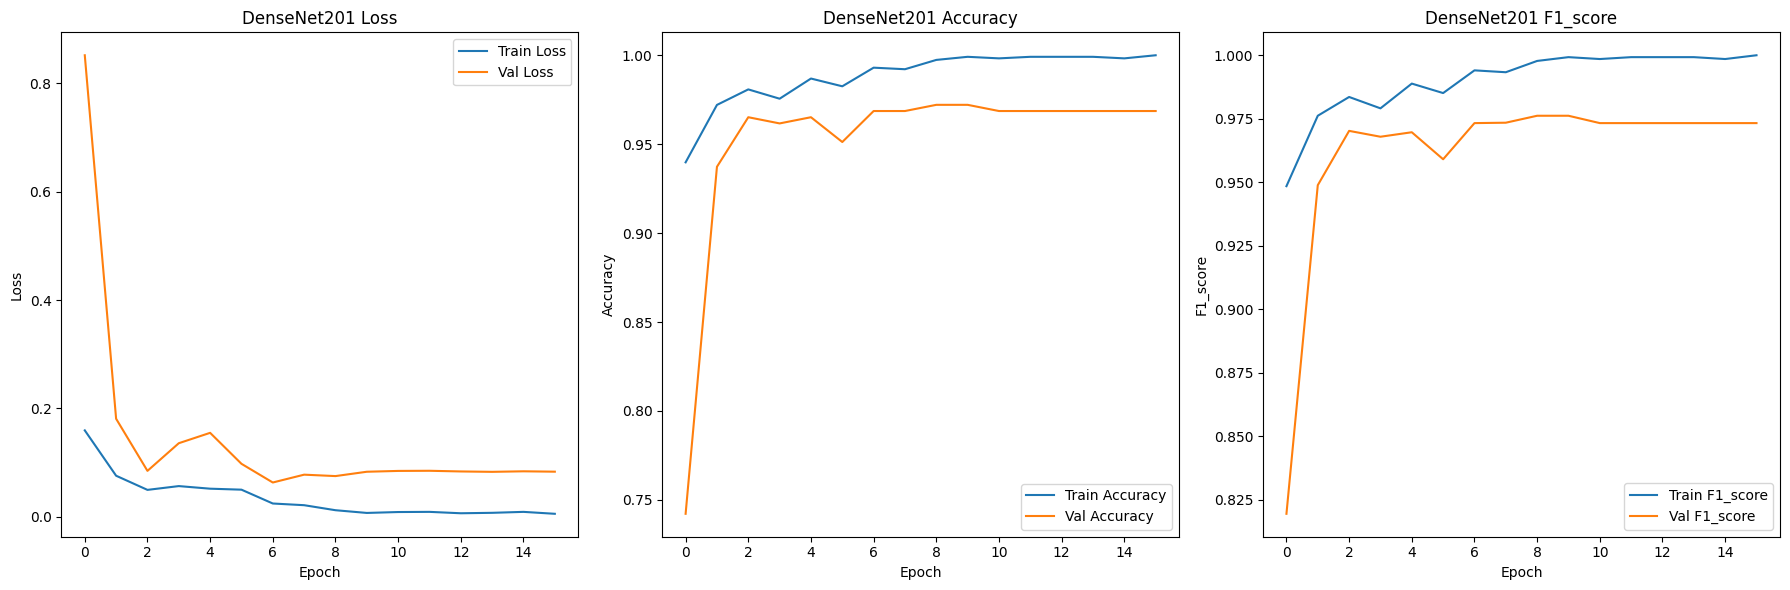


Loading best DenseNet201 model for final validation evaluation...
18/18 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step

--- Final Validation Set Performance (Best DenseNet201 Model) ---
Accuracy: 0.9721
F1-Score: 0.9762
AUC: 0.9971

Classification Report (Validation - DenseNet201):
              precision    recall  f1-score   support

 Non-Mitosis       0.96      0.97      0.97       118
     Mitosis       0.98      0.97      0.98       169

    accuracy                           0.97       287
   macro avg       0.97      0.97      0.97       287
weighted avg       0.97      0.97      0.97       287



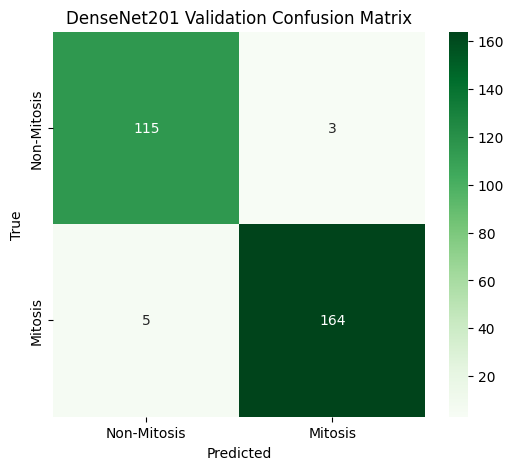


Predicting on test set with DenseNet201...
Loading best weights from /content/best_densenet201_model.keras for test prediction.
84/84 ━━━━━━━━━━━━━━━━━━━━ 51s 392ms/step

Found 1337 predictions for the test set (DenseNet201).
Submission template has 1443 rows.
Rows in submission template matched with DenseNet201 predictions: 1109
DenseNet201 submission file saved to /content/submission_densenet201.csv
Mitosis predictions in DenseNet201 submission: 153 out of 1443


In [ ]:
import json
import os
import math
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

# Import DenseNet201 and its preprocessing function
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix, classification_report

# --- Configuration & Paths (Updated for DenseNet201) ---
TRAIN_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_training/"
TEST_DIR = "/content/glioma_data/Data_122824/Glioma_MDC_2025_test/"
SUBMISSION_TEMPLATE_PATH = "/content/glioma_data/archive/Submission_template.csv"
MODEL_SAVE_PATH_DENSENET = "/content/best_densenet201_model.keras"
SUBMISSION_FILE_PATH_DENSENET = "/content/submission_densenet201.csv"


IMAGE_SIZE = 224 # Standard for DenseNet models
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
DROPOUT_RATE = 0.3

# --- Helper Functions (same as before) ---
def get_bbox(points, img_width, img_height):
    if not points: return None
    xs = [p[0] for p in points]; ys = [p[1] for p in points]
    if not xs or not ys: return None
    min_x = max(0, int(math.floor(min(xs)))); max_x = min(img_width, int(math.ceil(max(xs))))
    min_y = max(0, int(math.floor(min(ys)))); max_y = min(img_height, int(math.ceil(max(ys))))
    if min_x >= max_x or min_y >= max_y: return None
    return [min_x, min_y, max_x, max_y]

def parse_json_data(json_path, data_dir, is_test=False):
    samples = []
    with open(json_path, 'r') as f: data = json.load(f)
    image_filename = os.path.basename(json_path).replace('.json', '.jpg')
    image_path = os.path.join(data_dir, image_filename)
    if not os.path.exists(image_path): return samples
    try:
        with Image.open(image_path) as img: img_width, img_height = img.size
    except Exception: return samples
    for shape in data['shapes']:
        label_or_id = shape['label']
        bbox = get_bbox(shape['points'], img_width, img_height)
        if bbox:
            if is_test: samples.append((image_path, bbox, label_or_id))
            else: samples.append((image_path, bbox, 1 if label_or_id == 'Mitosis' else 0))
    return samples

# --- Keras Data Generator   ---
class KerasGliomaDataGenerator(keras.utils.Sequence):
    def __init__(self, samples, batch_size, image_size, shuffle=True, is_test=False, augment=False):
        super().__init__()
        self.samples = samples; self.batch_size = batch_size
        self.image_size = (image_size, image_size); self.shuffle = shuffle
        self.is_test = is_test; self.augment = augment
        self.image_cache = {}; self.indexes = np.arange(len(self.samples))
        if self.shuffle: np.random.shuffle(self.indexes)
    def __len__(self): return math.ceil(len(self.samples) / self.batch_size)
    def on_epoch_end(self):
        if self.shuffle: np.random.shuffle(self.indexes)
    def _load_and_preprocess_image(self, image_path, bbox):
        if image_path not in self.image_cache:
            try: img_pil = Image.open(image_path).convert('RGB'); self.image_cache[image_path] = img_pil
            except Exception: return None
        else: img_pil = self.image_cache[image_path]
        try:
            cropped_roi = img_pil.crop(bbox)
            if cropped_roi.width == 0 or cropped_roi.height == 0: return None
            resized_roi = cropped_roi.resize((self.image_size[1], self.image_size[0]), Image.Resampling.LANCZOS)
            return keras.utils.img_to_array(resized_roi) # Returns 0-255 images
        except Exception: return None
    def _augment_image(self, image_np_array):
        image_tensor = tf.convert_to_tensor(image_np_array, dtype=tf.float32)
        if tf.random.uniform(()) > 0.5: image_tensor = tf.image.flip_left_right(image_tensor)
        if tf.random.uniform(()) > 0.5: image_tensor = tf.image.flip_up_down(image_tensor)
        return image_tensor.numpy()
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        images_batch = []; labels_batch = []
        for i in range(len(batch_indexes)):
            original_sample_index = batch_indexes[i]
            image_path, bbox, label_or_id = self.samples[original_sample_index]
            img_array = self._load_and_preprocess_image(image_path, bbox)
            if img_array is None: img_array = np.zeros((self.image_size[0],self.image_size[1],3),dtype=np.float32)
            if self.augment and not self.is_test: img_array = self._augment_image(img_array)
            images_batch.append(img_array)
            if not self.is_test: labels_batch.append(label_or_id)
        images_np_array = np.array(images_batch)
        if self.is_test: return images_np_array
        else: return images_np_array, np.array(labels_batch).reshape(-1, 1)

# --- Load and Prepare Data ---
print("Loading and preparing data samples...")
all_train_json_files = [os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) if f.endswith('.json')]
all_test_json_files = [os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) if f.endswith('.json')]
all_training_samples = [s for json_file in tqdm(all_train_json_files, desc="Parsing Train JSONs") for s in parse_json_data(json_file, TRAIN_DIR, is_test=False)]
all_test_samples = [s for json_file in tqdm(all_test_json_files, desc="Parsing Test JSONs") for s in parse_json_data(json_file, TEST_DIR, is_test=True)]
print(f"Total training ROIs found: {len(all_training_samples)}")
print(f"Total test ROIs found: {len(all_test_samples)}")

if not all_training_samples: raise ValueError("No training samples found.")
train_labels_for_split = [s[2] for s in all_training_samples]
stratify_labels = train_labels_for_split if len(set(train_labels_for_split)) > 1 else None
train_samples, val_samples = train_test_split(all_training_samples, test_size=0.2, random_state=42, stratify=stratify_labels)
print(f"Train samples: {len(train_samples)}, Validation samples: {len(val_samples)}")

if not train_samples: raise ValueError("No samples in the training set after split.")
train_generator = KerasGliomaDataGenerator(train_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=True, augment=True)
val_generator = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False) if val_samples else None

# --- Model Definition (DenseNet201) ---
print("Defining DenseNet201 model...")
def create_densenet201_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=1, dropout_rate=DROPOUT_RATE):
    # Input layer for images in [0, 255] range
    original_inputs = Input(shape=input_shape)

    # Preprocessing layer specific to DenseNet
    preprocessed_inputs = Lambda(densenet_preprocess_input, name='preprocessing')(original_inputs)

    base_model = DenseNet201(
        include_top=False,
        weights="imagenet",
        input_tensor=preprocessed_inputs,
    )
    base_model.trainable = True # Full fine-tuning

    # Build the head
    x = base_model.output
    x = GlobalAveragePooling2D(name="avg_pool")(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='sigmoid', name="predictions")(x)

    # Create the full model
    model = Model(inputs=original_inputs, outputs=outputs)
    return model

densenet_model = create_densenet201_model()
densenet_model.summary()

# --- Compile Model ---
densenet_model.compile(
    optimizer=AdamW(learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.F1Score(average='micro', threshold=0.5, name='f1_score')]
)

# --- Callbacks ---
checkpoint_densenet = ModelCheckpoint(
    MODEL_SAVE_PATH_DENSENET, monitor='val_f1_score', save_best_only=True, mode='max', verbose=1)
reduce_lr_densenet = ReduceLROnPlateau(
    monitor='val_f1_score', factor=0.2, patience=3, mode='max', min_lr=1e-7, verbose=1)
early_stopping_densenet = EarlyStopping(
    monitor='val_f1_score', patience=7, mode='max', restore_best_weights=True, verbose=1)

# --- Training ---
print("Starting DenseNet201 training...")
history_densenet = densenet_model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    validation_data=val_generator,
    callbacks=[checkpoint_densenet, reduce_lr_densenet, early_stopping_densenet]
)
print("DenseNet201 training finished.")

# --- Plot Training History ---
if history_densenet and history_densenet.history:
    plt.figure(figsize=(18, 6))
    metrics_to_plot = ['loss', 'accuracy', 'f1_score']
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(1, len(metrics_to_plot), i + 1)
        plt.plot(history_densenet.history[metric], label=f'Train {metric.capitalize()}')
        if f'val_{metric}' in history_densenet.history:
            plt.plot(history_densenet.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'DenseNet201 {metric.capitalize()}')
        plt.xlabel('Epoch'); plt.ylabel(metric.capitalize()); plt.legend()
    plt.tight_layout(); plt.show()
else: print("No training history to plot for DenseNet201.")

# --- Evaluation on Validation Set with Best Model ---
if val_samples:
    print("\nLoading best DenseNet201 model for final validation evaluation...")
    if os.path.exists(MODEL_SAVE_PATH_DENSENET): densenet_model.load_weights(MODEL_SAVE_PATH_DENSENET)
    else: print(f"Warning: Model file {MODEL_SAVE_PATH_DENSENET} not found. Using current model weights.")

    val_generator_eval = KerasGliomaDataGenerator(val_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False)
    val_preds_probs = densenet_model.predict(val_generator_eval, verbose=1)
    val_preds_binary = (val_preds_probs > 0.5).astype(int).flatten()
    true_val_labels = np.concatenate([val_generator_eval[i][1] for i in range(len(val_generator_eval))]).flatten()
    true_val_labels = true_val_labels[:len(val_preds_binary)]

    if true_val_labels.size > 0:
        final_val_acc = accuracy_score(true_val_labels, val_preds_binary)
        final_val_f1 = f1_score(true_val_labels, val_preds_binary)
        try: final_val_auc = roc_auc_score(true_val_labels, val_preds_probs.flatten()[:len(true_val_labels)])
        except ValueError as e: print(f"AUC calculation error: {e}. Setting AUC to 0.0."); final_val_auc = 0.0
        print("\n--- Final Validation Set Performance (Best DenseNet201 Model) ---")
        print(f"Accuracy: {final_val_acc:.4f}\nF1-Score: {final_val_f1:.4f}\nAUC: {final_val_auc:.4f}")
        print("\nClassification Report (Validation - DenseNet201):")
        print(classification_report(true_val_labels, val_preds_binary, target_names=['Non-Mitosis', 'Mitosis'], zero_division=0))
        cm = confusion_matrix(true_val_labels, val_preds_binary)
        plt.figure(figsize=(6,5)); sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Mitosis', 'Mitosis'], yticklabels=['Non-Mitosis', 'Mitosis']) # Changed cmap
        plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('DenseNet201 Validation Confusion Matrix'); plt.show()
    else: print("No data in validation set to evaluate for DenseNet201.")
else: print("Skipping validation set evaluation.")

# --- Prediction on Test Set & Submission File Generation ---
print("\nPredicting on test set with DenseNet201...")
if not all_test_samples: print("No test samples found. Skipping prediction.")
else:
    test_generator = KerasGliomaDataGenerator(all_test_samples, BATCH_SIZE, IMAGE_SIZE, shuffle=False, is_test=True)
    if os.path.exists(MODEL_SAVE_PATH_DENSENET):
        print(f"Loading best weights from {MODEL_SAVE_PATH_DENSENET} for test prediction.")
        densenet_model.load_weights(MODEL_SAVE_PATH_DENSENET)
    else: print(f"Warning: Model file {MODEL_SAVE_PATH_DENSENET} not found. Using current model weights for test set.")

    test_preds_all_probs = densenet_model.predict(test_generator, verbose=1)
    test_preds_all_binary = (test_preds_all_probs > 0.5).astype(int).flatten()
    if len(test_preds_all_binary) != len(all_test_samples): print(f"CRITICAL WARNING: Mismatch in test prediction count!")

    predictions_dict_densenet = {}
    for i, sample_info in enumerate(all_test_samples):
        image_path, _, roi_id = sample_info
        image_id_from_path = os.path.basename(image_path).split('.')[0]
        if i < len(test_preds_all_binary): predictions_dict_densenet[(image_id_from_path, roi_id)] = test_preds_all_binary[i]
        else: predictions_dict_densenet[(image_id_from_path, roi_id)] = 0

    print(f"\nFound {len(predictions_dict_densenet)} predictions for the test set (DenseNet201).")
    submission_df_densenet = pd.read_csv(SUBMISSION_TEMPLATE_PATH)
    print(f"Submission template has {len(submission_df_densenet)} rows.")
    submission_df_densenet['Prediction'] = submission_df_densenet.apply(
        lambda row: predictions_dict_densenet.get((row['Image ID'], row['Label ID']), 0), axis=1)

    matched_count = sum(1 for _, r in submission_df_densenet.iterrows() if (r['Image ID'], r['Label ID']) in predictions_dict_densenet)
    print(f"Rows in submission template matched with DenseNet201 predictions: {matched_count}")

    submission_df_densenet.to_csv(SUBMISSION_FILE_PATH_DENSENET, index=False)
    print(f"DenseNet201 submission file saved to {SUBMISSION_FILE_PATH_DENSENET}")
    if len(submission_df_densenet) > 0: print(f"Mitosis predictions in DenseNet201 submission: {submission_df_densenet['Prediction'].sum()} out of {len(submission_df_densenet)}")
    else: print("Submission DataFrame for DenseNet201 is empty.")

# from google.colab import files
# files.download(SUBMISSION_FILE_PATH_DENSENET)
# files.download(MODEL_SAVE_PATH_DENSENET)